# First attempt of Kr selection for map with source and XRay correction

In [313]:
import pandas as pd
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.colors import LogNorm
from scipy.interpolate import interp1d
from scipy.signal import find_peaks

module_dir = os.path.abspath('../src')  # Adjust path as needed
sys.path.append(module_dir)

from parser_fun import merge_hdfs_multi
from plot_functions import auto_plot_style
from plot_functions import color_sequence
import plot_functions as pf

import analysis_functions as af
import stats

#Can be removed later
import importlib
importlib.reload(af)
importlib.reload(stats)
#

<module 'stats' from '/Users/samuele/Documents/Postdoc/NEXT/ASpirit/src/stats.py'>

In [3]:
run_number = 15586
folderdata = [f"/Users/samuele/Documents/Postdoc/NEXT/TrgEff/data/{run_number}/"]

In [4]:
df = merge_hdfs_multi(folderdata)

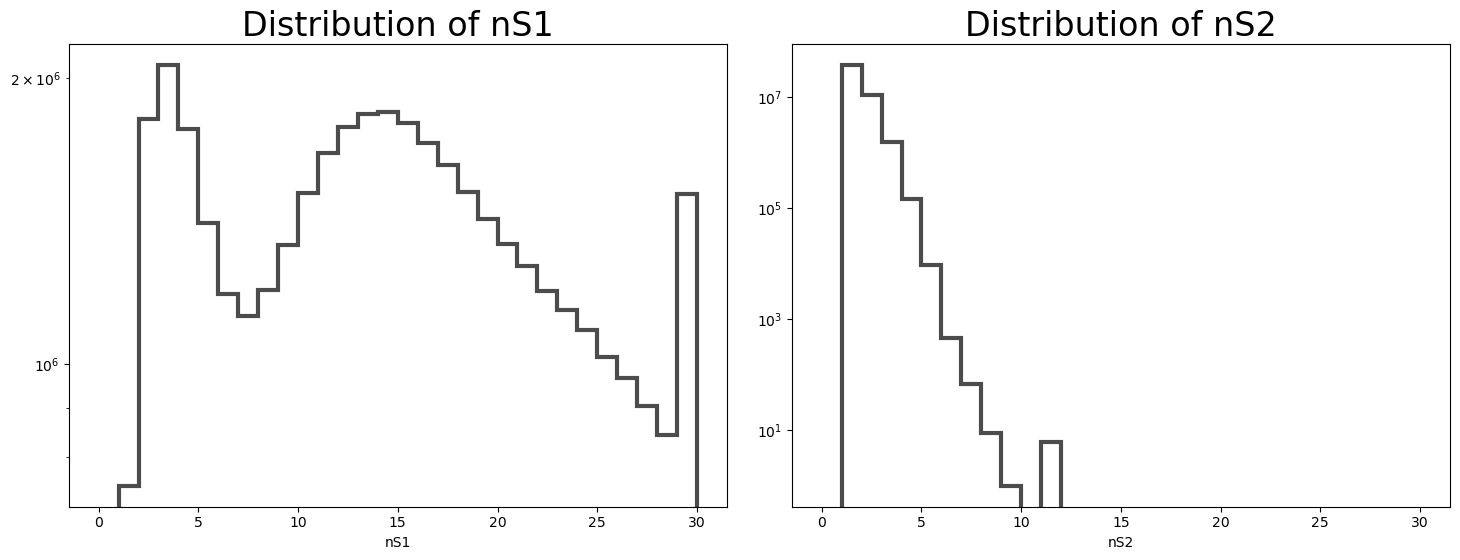

In [5]:
# Create a figure with three subplots in a row
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
auto_plot_style()

# Plot histogram of df_sel['s1w']
axes[0].hist(df[df['s2_peak']==0]['nS1'], bins=30, range=[0,30], histtype='step', color = color_sequence[0], alpha=0.7)
axes[0].set_xlabel('nS1')
axes[0].set_title('Distribution of nS1')
axes[0].set_yscale('log')

# Plot histogram of df_sel['s1e']
axes[1].hist(df[df['s2_peak']==0]['nS2'], bins=30, range = [0,30], histtype='step',color = color_sequence[0], alpha=0.7)
axes[1].set_xlabel('nS2')
axes[1].set_yscale('log')
axes[1].set_title('Distribution of nS2')

# Adjust layout for better spacing
plt.tight_layout()

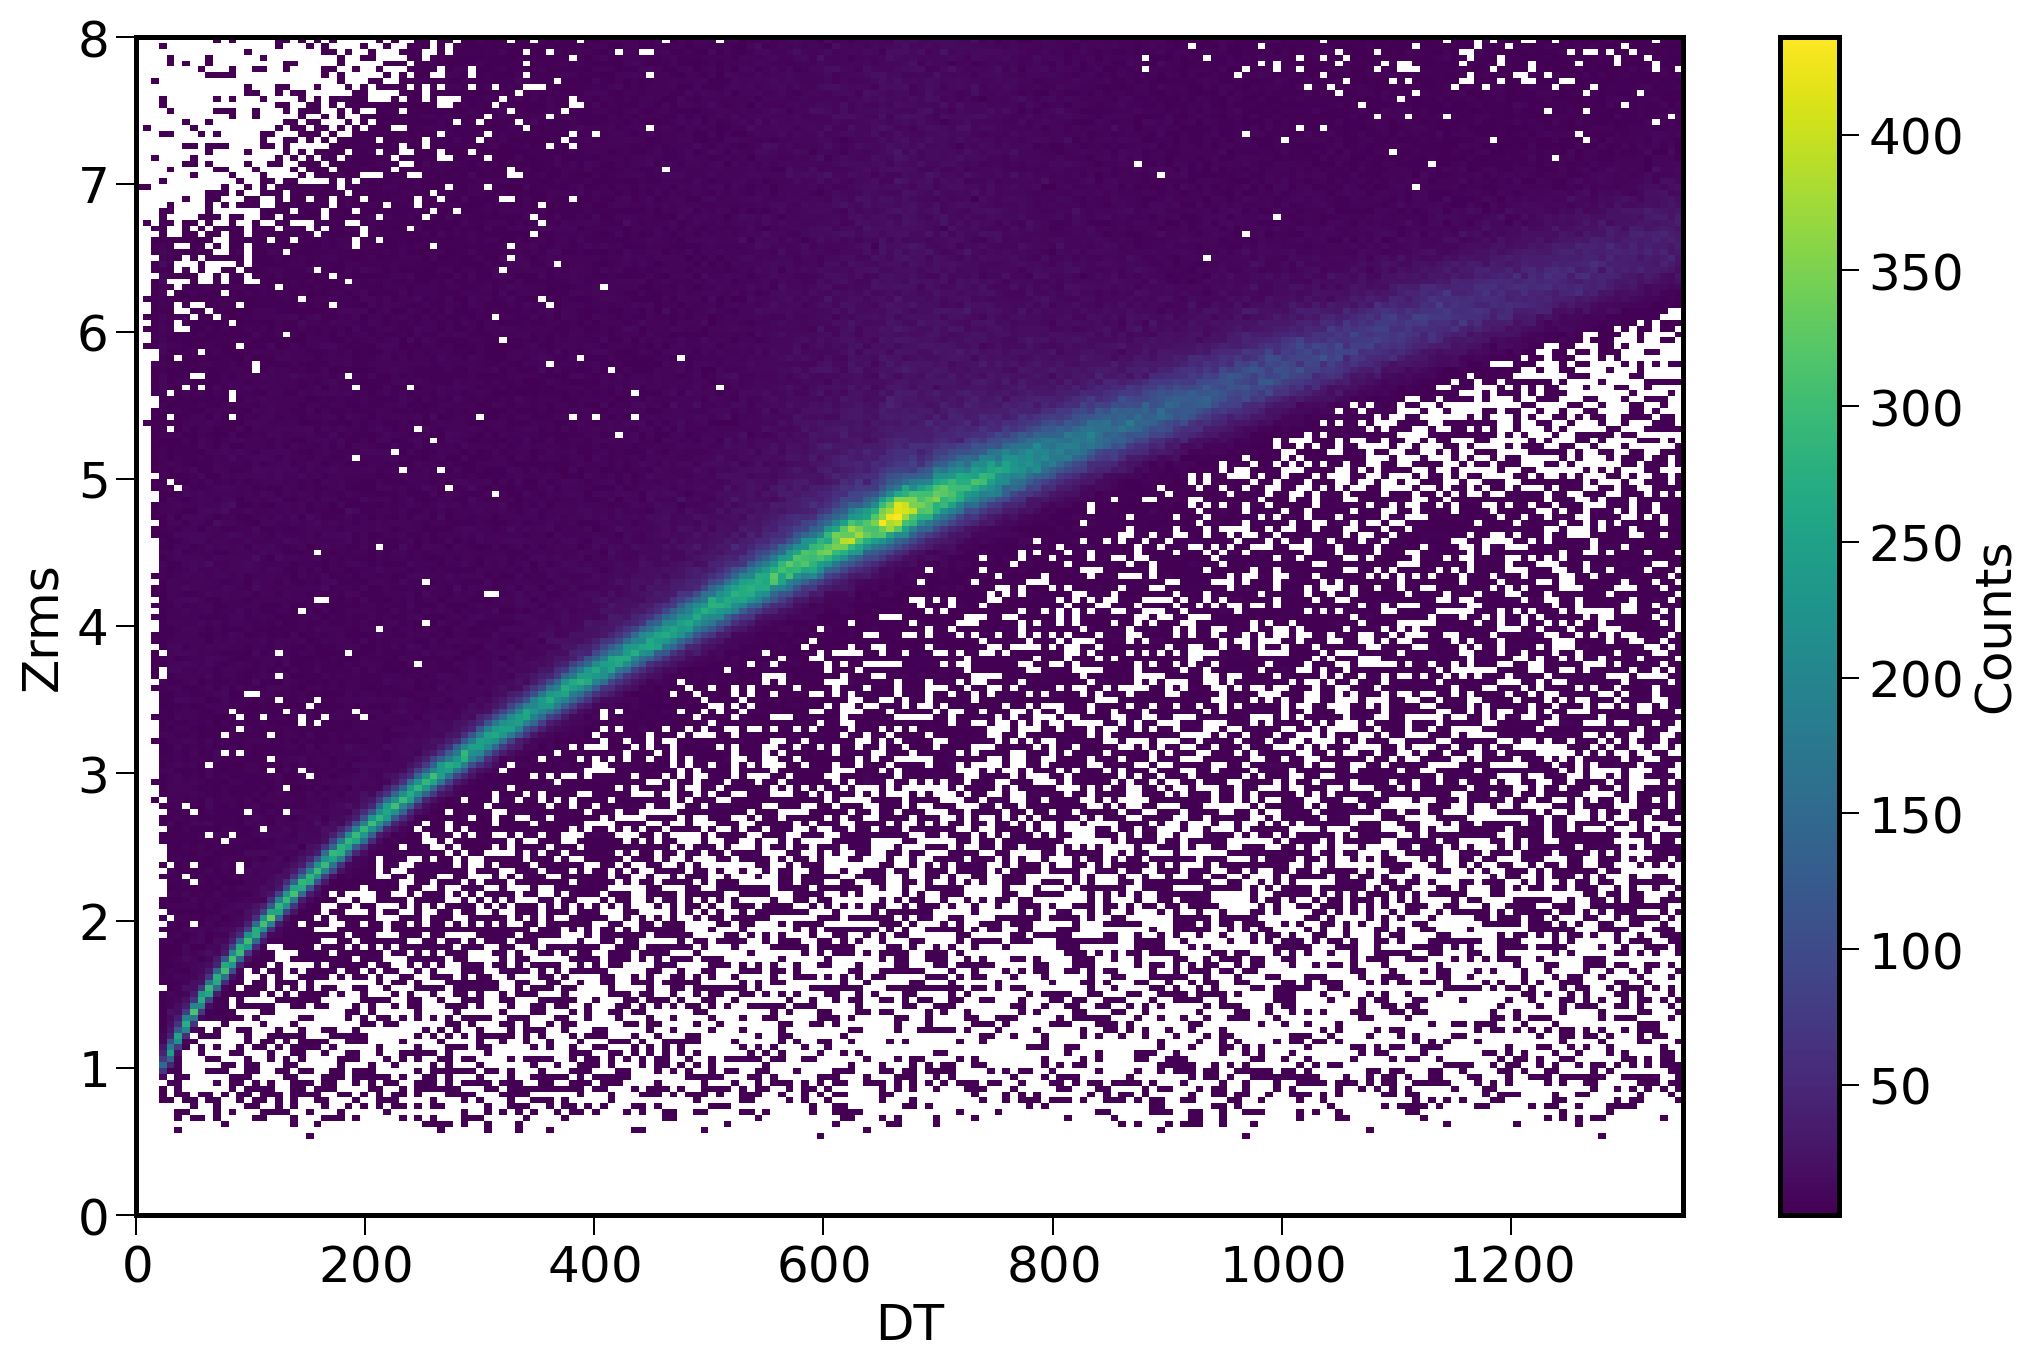

In [6]:
# Compute the 2D histogram data without plotting
counts, xedges, yedges = np.histogram2d(
    df[ (df['nS1']==1) & (df['nS2']==1) ]['DT'], 
    df[ (df['nS1']==1) & (df['nS2']==1) ]['Zrms'], 
    bins=200, range = ([0,1350],[0,8]))

# Mask bins with counts ≤ 1
counts[counts <= 1] = np.nan  # Convert low-count bins to NaN (displayed as white)

# Create the 2D histogram plot with masked data
plt.figure(figsize=(12, 8),dpi=180)

plt.pcolormesh(xedges, yedges, counts.T, cmap='viridis')
# Add labels and title
plt.xlabel('DT')
plt.ylabel('Zrms')

# Add colorbar to indicate counts
plt.colorbar(label='Counts')
plt.tight_layout()
plt.show()


### Diffusion band selection

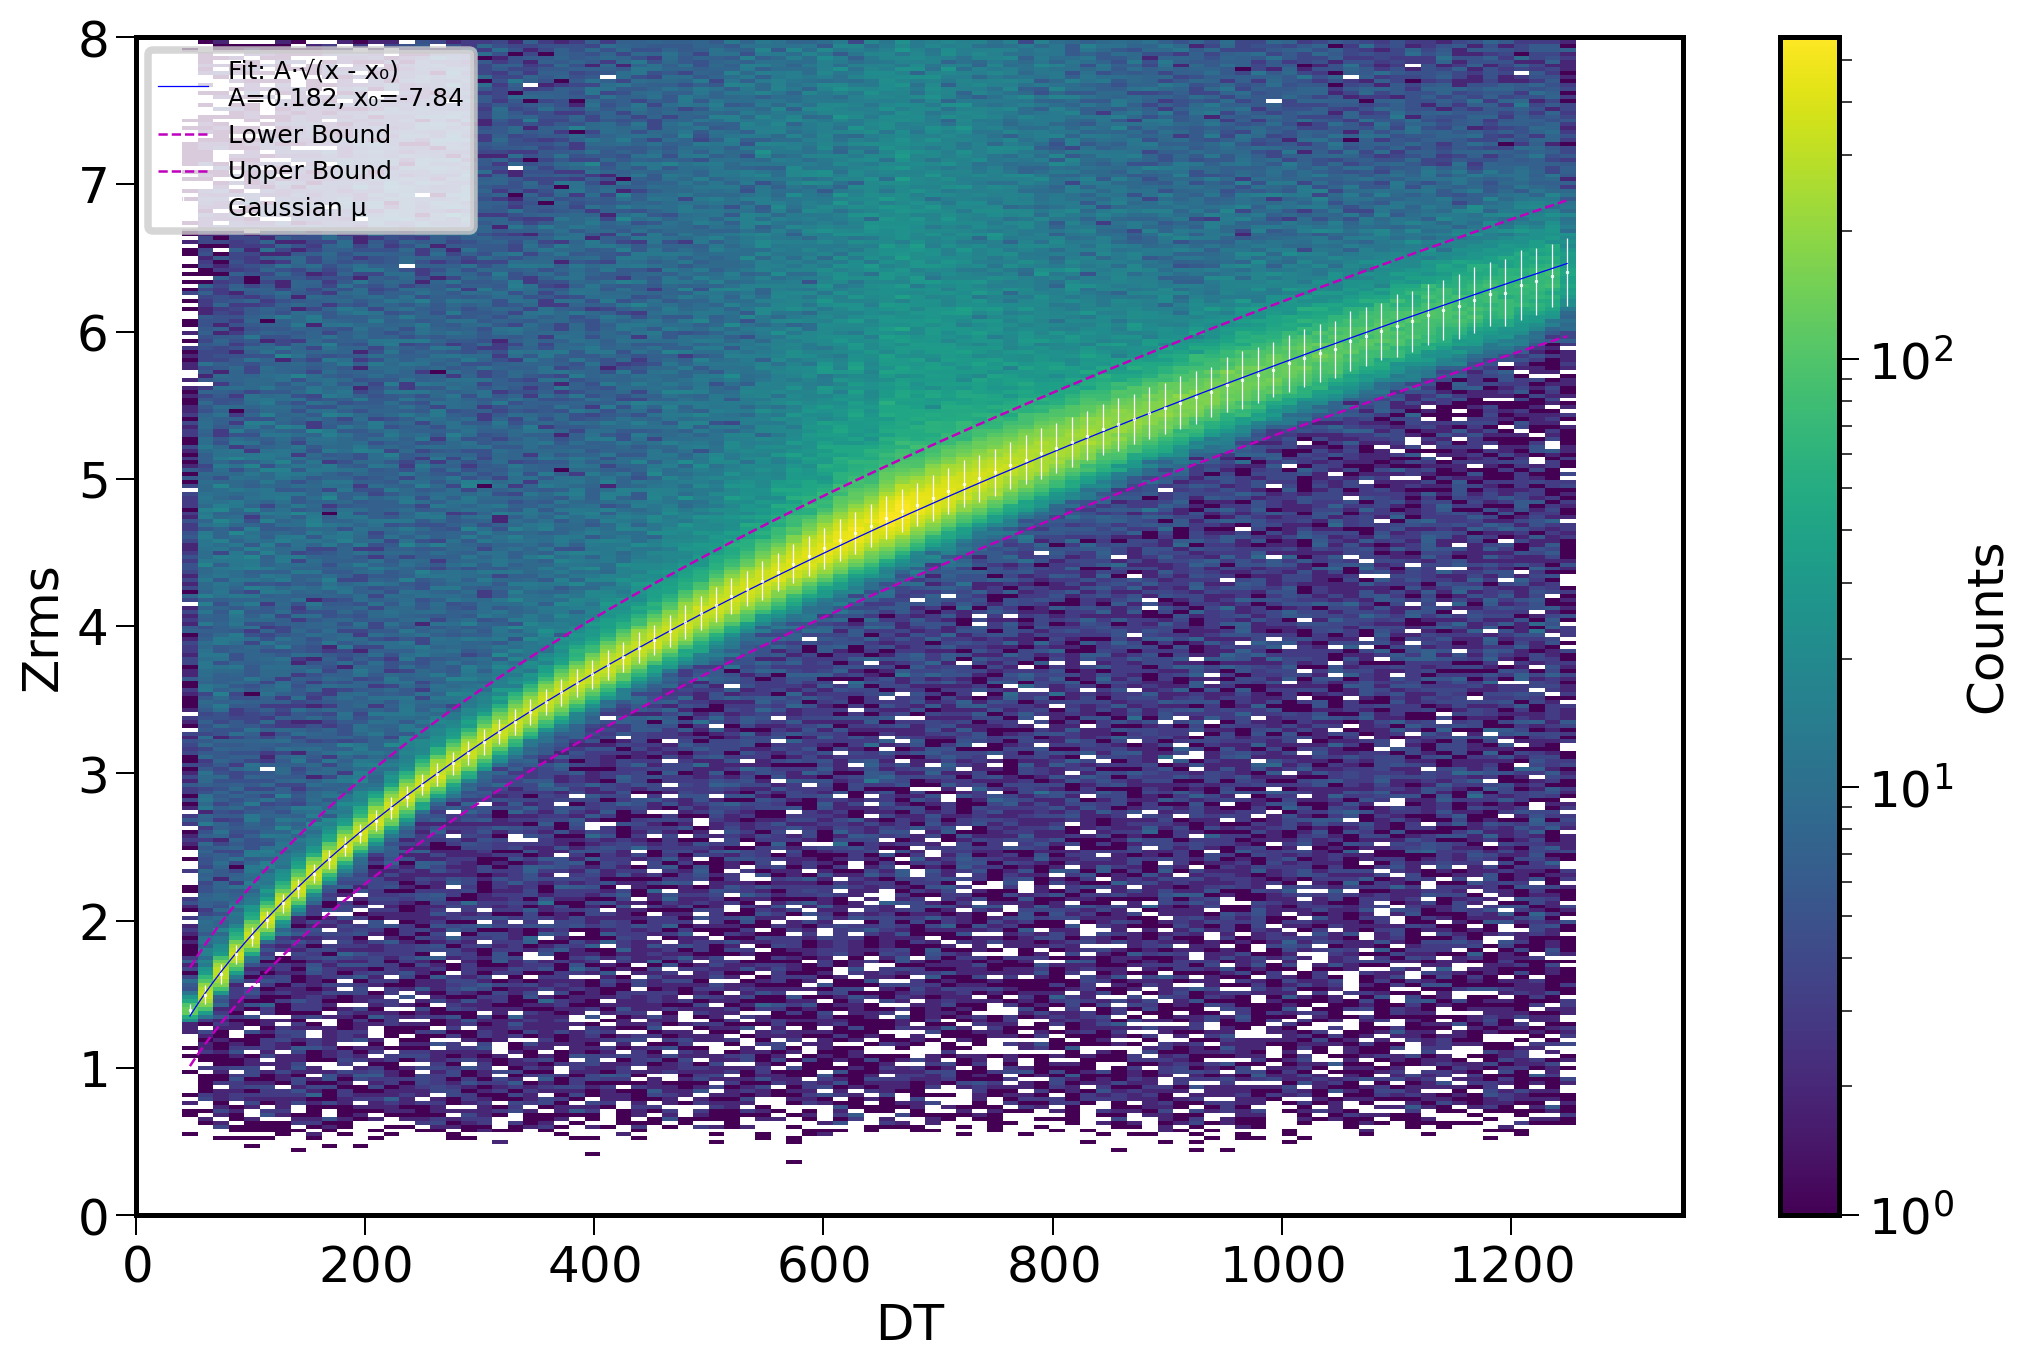

In [14]:
def sqrt_function(x, A, x0):
    return A * np.sqrt(x - x0)

counts, xedges, yedges = np.histogram2d(
    df[(df['DT'] > 50) & (df['DT'] < 1250) & (df['nS1']==1) & (df['nS2']==1)]['DT'],
    df[(df['DT'] > 50) & (df['DT'] < 1250) & (df['nS1']==1) & (df['nS2']==1)]['Zrms'],
    bins=(100, 300), range=([0, 1350], [0, 8])
)

dt_centers, mean_vals, mean_errs, sigma, sigma_errs = af.gaussian_profiler_y(counts, xedges, yedges)

popt_sqrt, pcov_sqrt = curve_fit(sqrt_function, dt_centers, mean_vals, sigma=mean_errs, p0=[0.1,-0.1])

plt.figure(figsize=(12, 8), dpi=180)

# Plot 2D histogram
plt.imshow(
    counts.T,
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    aspect='auto',
    origin='lower',
    cmap='viridis',
    norm = LogNorm()
)

# Overlay mean values and fit
plt.errorbar(dt_centers, mean_vals, yerr=sigma, fmt='.', markersize=.7, linewidth=.5, color='white', label='Gaussian μ')
xfit = np.linspace(min(dt_centers), max(dt_centers), 500)

plt.plot(xfit, sqrt_function(xfit, *popt_sqrt), 'b-', linewidth=.5, label=f'Fit: A·√(x - x₀)\nA={popt_sqrt[0]:.3f}, x₀={popt_sqrt[1]:.2f}')

y_center = sqrt_function(xfit, *popt_sqrt)
lower_bound = y_center - 0.3 - 0.03 * y_center
upper_bound = y_center + 0.3 + 0.02 * y_center

plt.plot(xfit, lower_bound, 'm--', linewidth=1., label='Lower Bound')
plt.plot(xfit, upper_bound, 'm--', linewidth=1., label='Upper Bound')

# Labels and aesthetics
plt.xlabel('DT')
plt.ylabel('Zrms')
plt.colorbar(label='Counts')
plt.grid(False)
plt.legend(fontsize=10)
plt.tight_layout()

In [15]:
df_sel_diff = df[ (df['Zrms'] > sqrt_function(df['DT'],*popt_sqrt)-0.3-0.03*sqrt_function(df['DT'],*popt_sqrt) ) 
                    & (df['Zrms'] < sqrt_function(df['DT'],*popt_sqrt)+0.3+0.02*sqrt_function(df['DT'],*popt_sqrt) )  ]

print(f"NEvent filtered road : {len(np.unique(df_sel_diff['event']))}")
print(f"eff:{(len(np.unique(df_sel_diff['event']))/len(np.unique(df['event'])))*100:.2f}%")

/Users/samuele/Software/miniforge3/envs/IC/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


NEvent filtered road : 4026045
eff:71.89%


### 1S1 & 1S2 left selection

In [16]:
df_single_s1_peak = df_sel_diff.groupby('time').filter(lambda x: (x['s1_peak'].count() == 1) & (x['s2_peak'].count() == 1))

print(f"NEvent filtered road : {len(np.unique(df_single_s1_peak['event']))}")
print(f"eff:{(len(np.unique(df_single_s1_peak['event']))/len(np.unique(df['event'])))*100:.2f}%")

NEvent filtered road : 2025298
eff:36.17%


### Geometric Selection

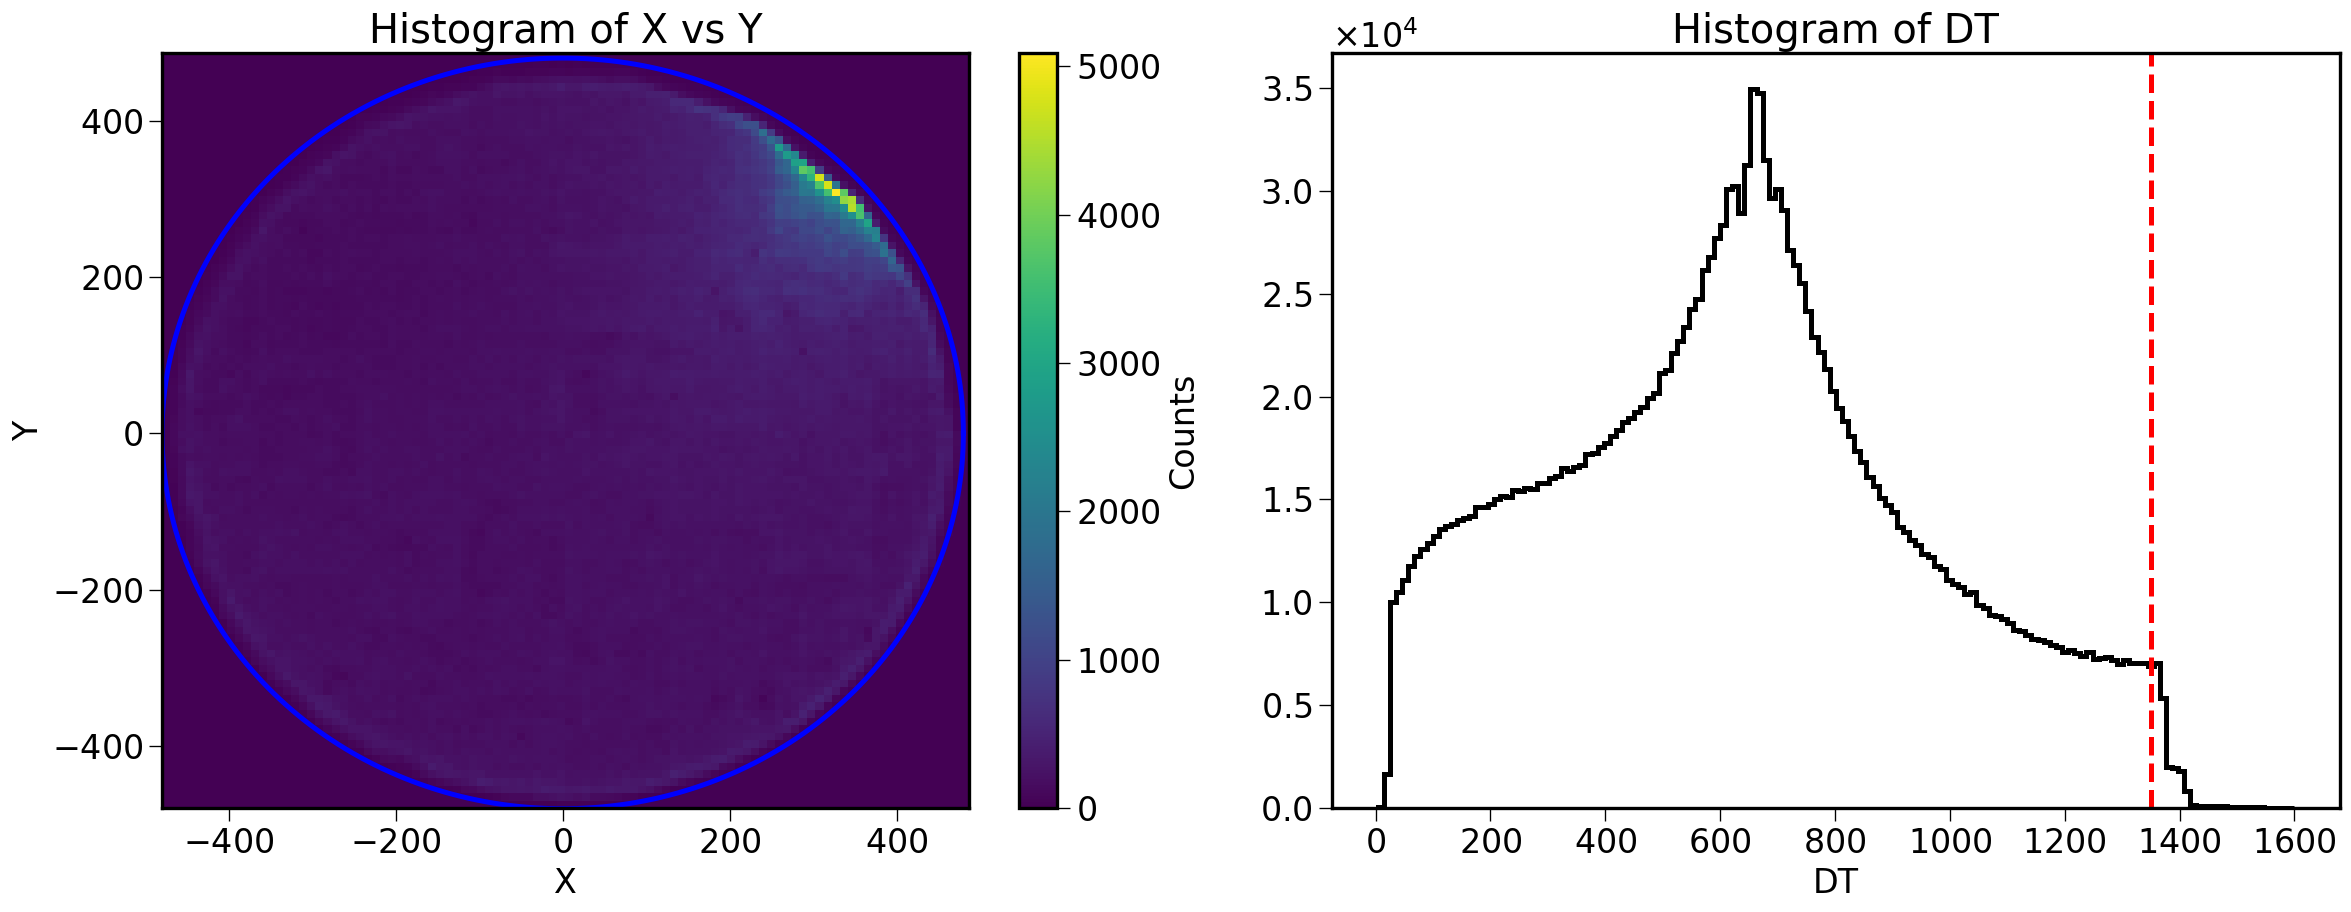

In [17]:
#GeoSel
rad = 480
z = 1350

# Create a figure with two subplots in a row
fig, axes = plt.subplots(1, 2, figsize=(20, 8), dpi=120)

# Plot histogram of X vs Y
axes[0].hist2d(df_single_s1_peak['X'], df_single_s1_peak['Y'], bins=100, cmap='viridis')
axes[0].set_xlabel('X')
axes[0].set_ylabel('Y')
axes[0].set_title('Histogram of X vs Y')
plt.colorbar(axes[0].collections[0], ax=axes[0], label='Counts')

# Generate points for the circumference
theta = np.linspace(0, 2 * np.pi, 300)
x_circle = 0 + rad * np.cos(theta)
y_circle = 0 + rad * np.sin(theta)
# Plot the circumference
axes[0].plot(x_circle, y_circle, color='blue')

# Plot histogram of X vs DT
axes[1].hist(df_single_s1_peak['DT'], bins=150,histtype='step')
axes[1].set_xlabel('DT')
axes[1].set_title('Histogram of DT')
#axes[1].set_ylim([0,4000])
# Plot the vertical line at x = 1000
axes[1].axvline(x=z, color='red', linestyle='--', label='Vertical Line (x=1000)')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [18]:
df_single_s1_peak_geo = df_single_s1_peak[ (df_single_s1_peak['DT']<1350) & (np.sqrt(df_single_s1_peak['X']**2 + df_single_s1_peak['Y']**2)<480 )   ]

print(f"NEvent filtered road : {len(np.unique(df_single_s1_peak['event']))}")
print(f"eff:{(len(np.unique(df_single_s1_peak_geo['event']))/len(np.unique(df['event'])))*100:.2f}%")

NEvent filtered road : 2025298
eff:35.74%


### Look at the data 

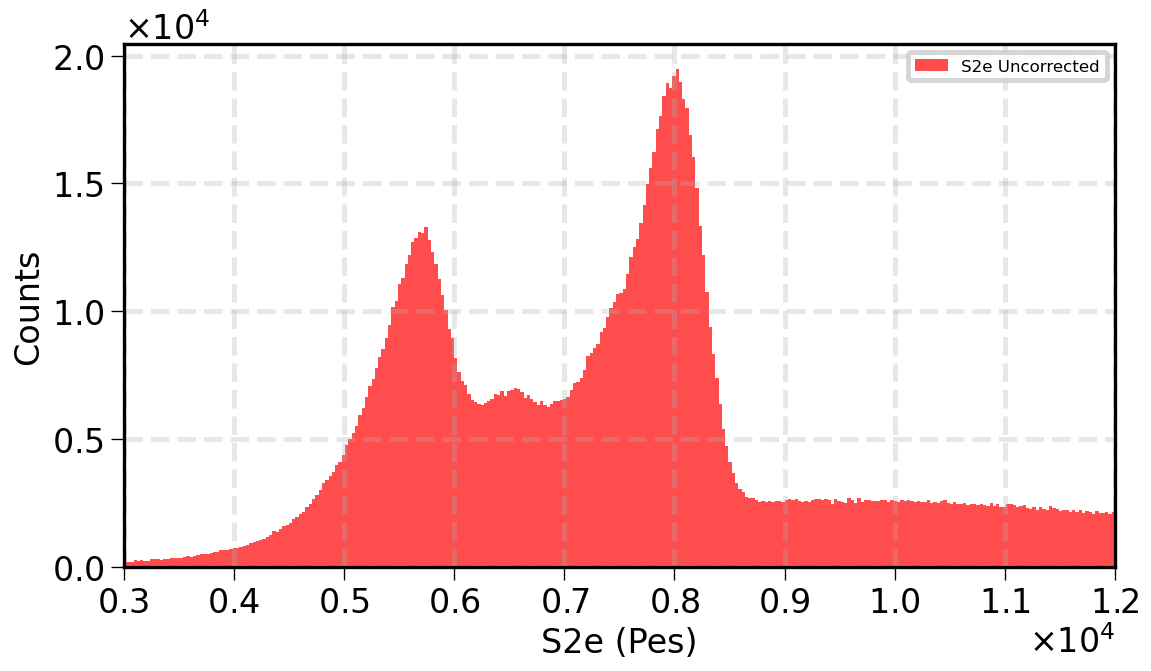

In [19]:
# Plot the histogram of S2e
plt.figure(figsize=(10, 6),dpi=120)
counts_S2e, bins, patches = plt.hist(df_single_s1_peak_geo['S2e'], bins=400, range=[0, 12000], 
                                color='red', alpha=0.7, label='S2e Uncorrected')

plt.xlabel('S2e (Pes)')
plt.ylabel('Counts')
plt.legend()
plt.xlim([3000,12000])

# Show the plot
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.legend(fontsize=10)
plt.show()

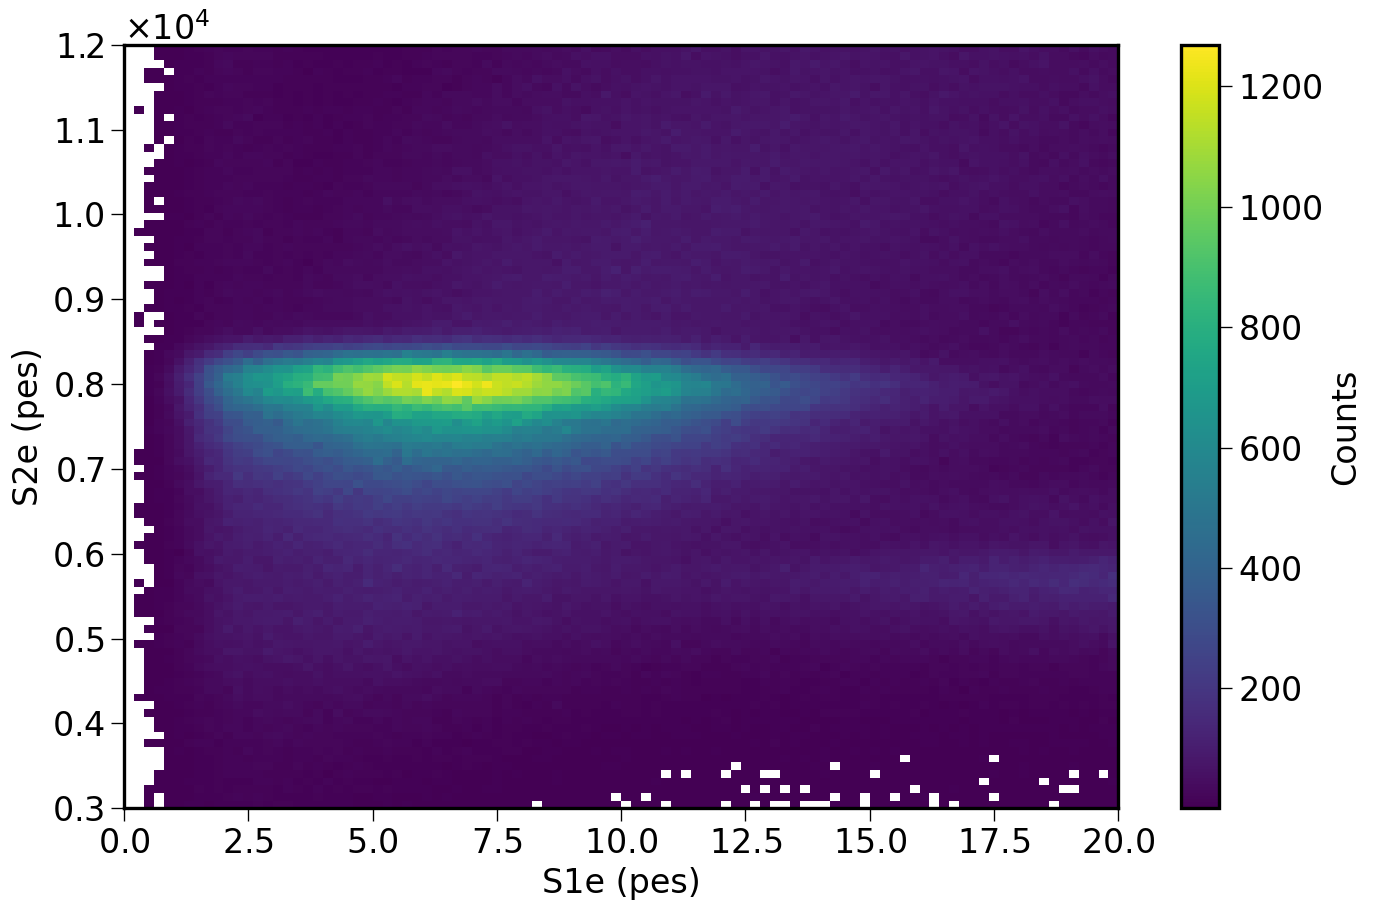

In [20]:
plt.figure(figsize=(12, 8), dpi=120)

counts, xedges, yedges = np.histogram2d(
    df_single_s1_peak_geo['S1e'],
    df_single_s1_peak_geo['S2e'],
    bins=100,
    range=[(0, 20), (3000, 12000)]
)

# Mask bins with counts < 1
counts_masked = np.where(counts < 1, np.nan, counts)

# Plot with pcolormesh
X, Y = np.meshgrid(xedges, yedges)
plt.pcolormesh(X, Y, counts_masked.T, cmap='viridis', shading='auto')  # transpose counts to align axes

plt.colorbar(label='Counts')
plt.xlabel('S1e (pes)')
plt.ylabel('S2e (pes)')
plt.tight_layout()
plt.show()

/var/folders/pd/hx80lcqj1szc4vdz3mbmmv680000gn/T/ipykernel_97991/2560408748.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_single_s1_peak_geo['R'] = np.sqrt(df_single_s1_peak_geo['X']**2 + df_single_s1_peak_geo['Y']**2)


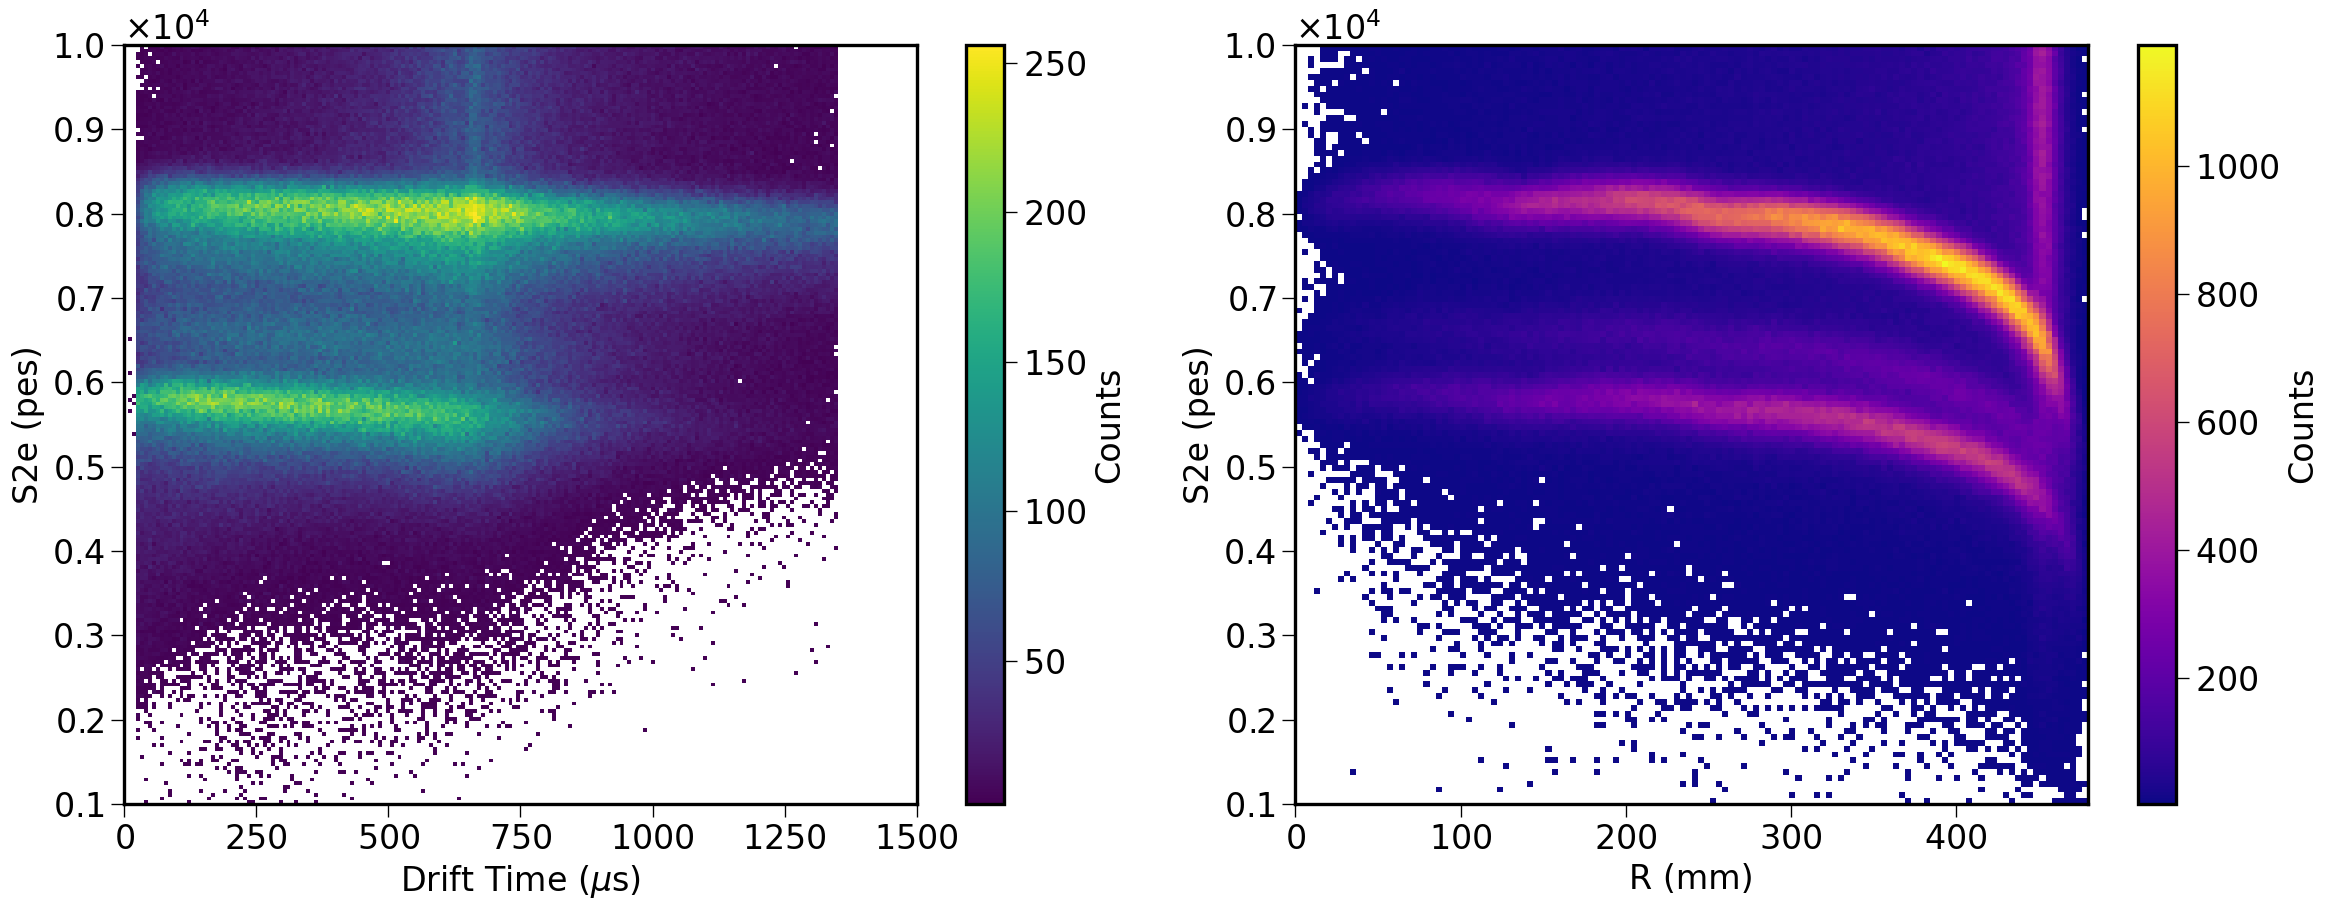

In [21]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8),dpi=120)

df_single_s1_peak_geo['R'] = np.sqrt(df_single_s1_peak_geo['X']**2 + df_single_s1_peak_geo['Y']**2)

# Plot 1: DT vs S2e
counts1, xedges1, yedges1 = np.histogram2d(df_single_s1_peak_geo['DT'], df_single_s1_peak_geo['S2e'], bins=200, range=([0, 1500], [1000, 10000]))
counts1[counts1 <= 1] = np.nan  # Mask bins with counts ≤ 1

axes[0].pcolormesh(xedges1, yedges1, counts1.T, cmap='viridis')
axes[0].set_xlabel('Drift Time ($\mu$s)')
axes[0].set_ylabel('S2e (pes)')
fig.colorbar(axes[0].collections[0], ax=axes[0], label='Counts')

# Compute histogram
counts2, xedges2, yedges2 = np.histogram2d(
    df_single_s1_peak_geo['R'],
    df_single_s1_peak_geo['S2e'],
    bins=130,
    range=([0, 480], [1000, 10000])
)

# Plot 2: sqrt(X^2 + Y^2) vs S2e
counts2, xedges2, yedges2 = np.histogram2d(df_single_s1_peak_geo['R'], df_single_s1_peak_geo['S2e'], bins=130, range=([0, 480], [1000, 10000]))
counts2[counts2 <= 1] = np.nan  # Mask bins with counts ≤ 1

axes[1].pcolormesh(xedges2, yedges2, counts2.T, cmap='plasma')
axes[1].set_xlabel('R (mm)')
axes[1].set_ylabel('S2e (pes)')
fig.colorbar(axes[1].collections[0], ax=axes[1], label='Counts')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

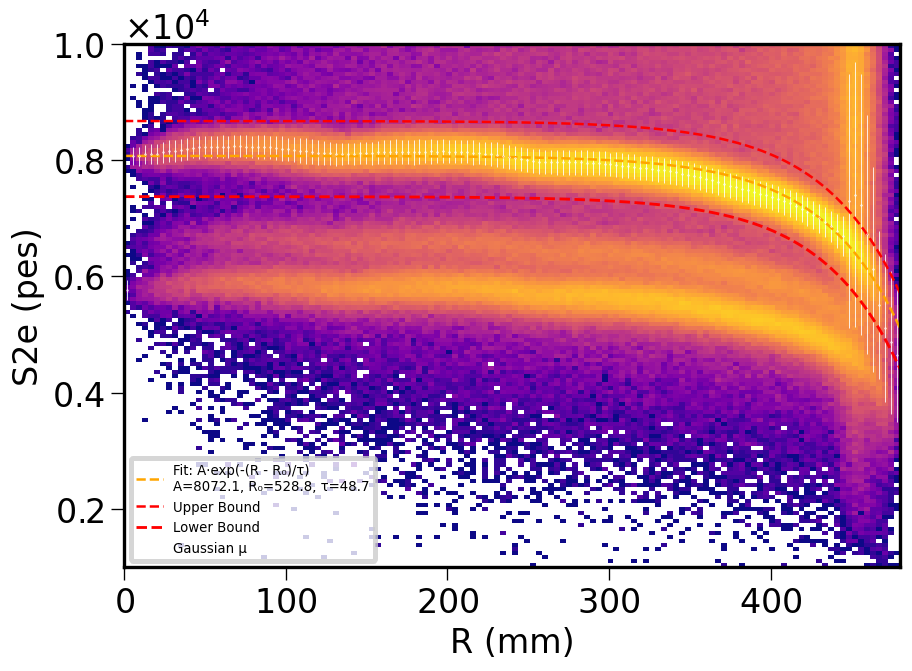

In [262]:
# Step 3: Fit with exponential model
def expo_model(R, A, R0, tau):
    return A *(1- np.exp((R - R0) / tau))

plt.figure(figsize=(8, 6), dpi=120)

counts2, xedges2, yedges2 = np.histogram2d(df_single_s1_peak_geo['R'], df_single_s1_peak_geo['S2e'], bins=130, range=([0, 480], [1000, 10000]))
dt_centers, mean_vals, mean_errs, sigma, sigma_errs = af.gaussian_profiler_y(counts2, xedges2, yedges2)

counts2[counts2 <= 1] = np.nan  # Mask bins with counts ≤ 1

p0=[8000, 600, 100]
popt, _ = curve_fit(expo_model, dt_centers, mean_vals, p0=p0)

plt.pcolormesh(xedges2, yedges2, counts2.T, cmap='plasma', norm = LogNorm())
plt.xlabel('R (mm)')
plt.ylabel('S2e (pes)')
fig.colorbar(axes[1].collections[0], ax=axes[1], label='Counts')
plt.errorbar(dt_centers, mean_vals, yerr=sigma, fmt='.', markersize=.7, linewidth=.5, color='white', label='Gaussian μ')

r_fit = np.linspace(0, 480, 500)
plt.plot(r_fit, expo_model(r_fit, *popt), color='orange', linestyle='--', linewidth=1.5, label=f'Fit: A·exp(-(R - R₀)/τ)\nA={popt[0]:.1f}, R₀={popt[1]:.1f}, τ={popt[2]:.1f}')
plt.plot(r_fit, expo_model(r_fit, *popt)+600, color='red', linestyle='--', linewidth=1.5, label=f'Upper Bound')
plt.plot(r_fit, expo_model(r_fit, *popt)-700, color='red', linestyle='--', linewidth=1.7, label=f'Lower Bound')

plt.legend(fontsize=8)
# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

In [332]:
Krdf = df_single_s1_peak_geo[(df_single_s1_peak_geo['S2e'] >= expo_model(df_single_s1_peak_geo['R'], *popt) - 700) & 
                             (df_single_s1_peak_geo['S2e'] <= expo_model(df_single_s1_peak_geo['R'], *popt) + 600)]

print(f"NEvent filtered road : {len(np.unique(Krdf['event']))}")
print(f"eff:{(len(np.unique(Krdf['event']))/len(np.unique(df['event'])))*100:.2f}%")

NEvent filtered road : 648702
eff:11.58%


In [333]:
bins_xy = 80
z_bins = np.array([])
z_bins = np.append(z_bins, 0)
z_bins = np.append(z_bins, np.linspace(150, 1150, 13))
z_bins = np.append(z_bins, 1350)
print(z_bins)
krmap = af.compute_map3D(Krdf, bins_xy = bins_xy, z_bins=z_bins)

[   0.          150.          233.33333333  316.66666667  400.
  483.33333333  566.66666667  650.          733.33333333  816.66666667
  900.          983.33333333 1066.66666667 1150.         1350.        ]


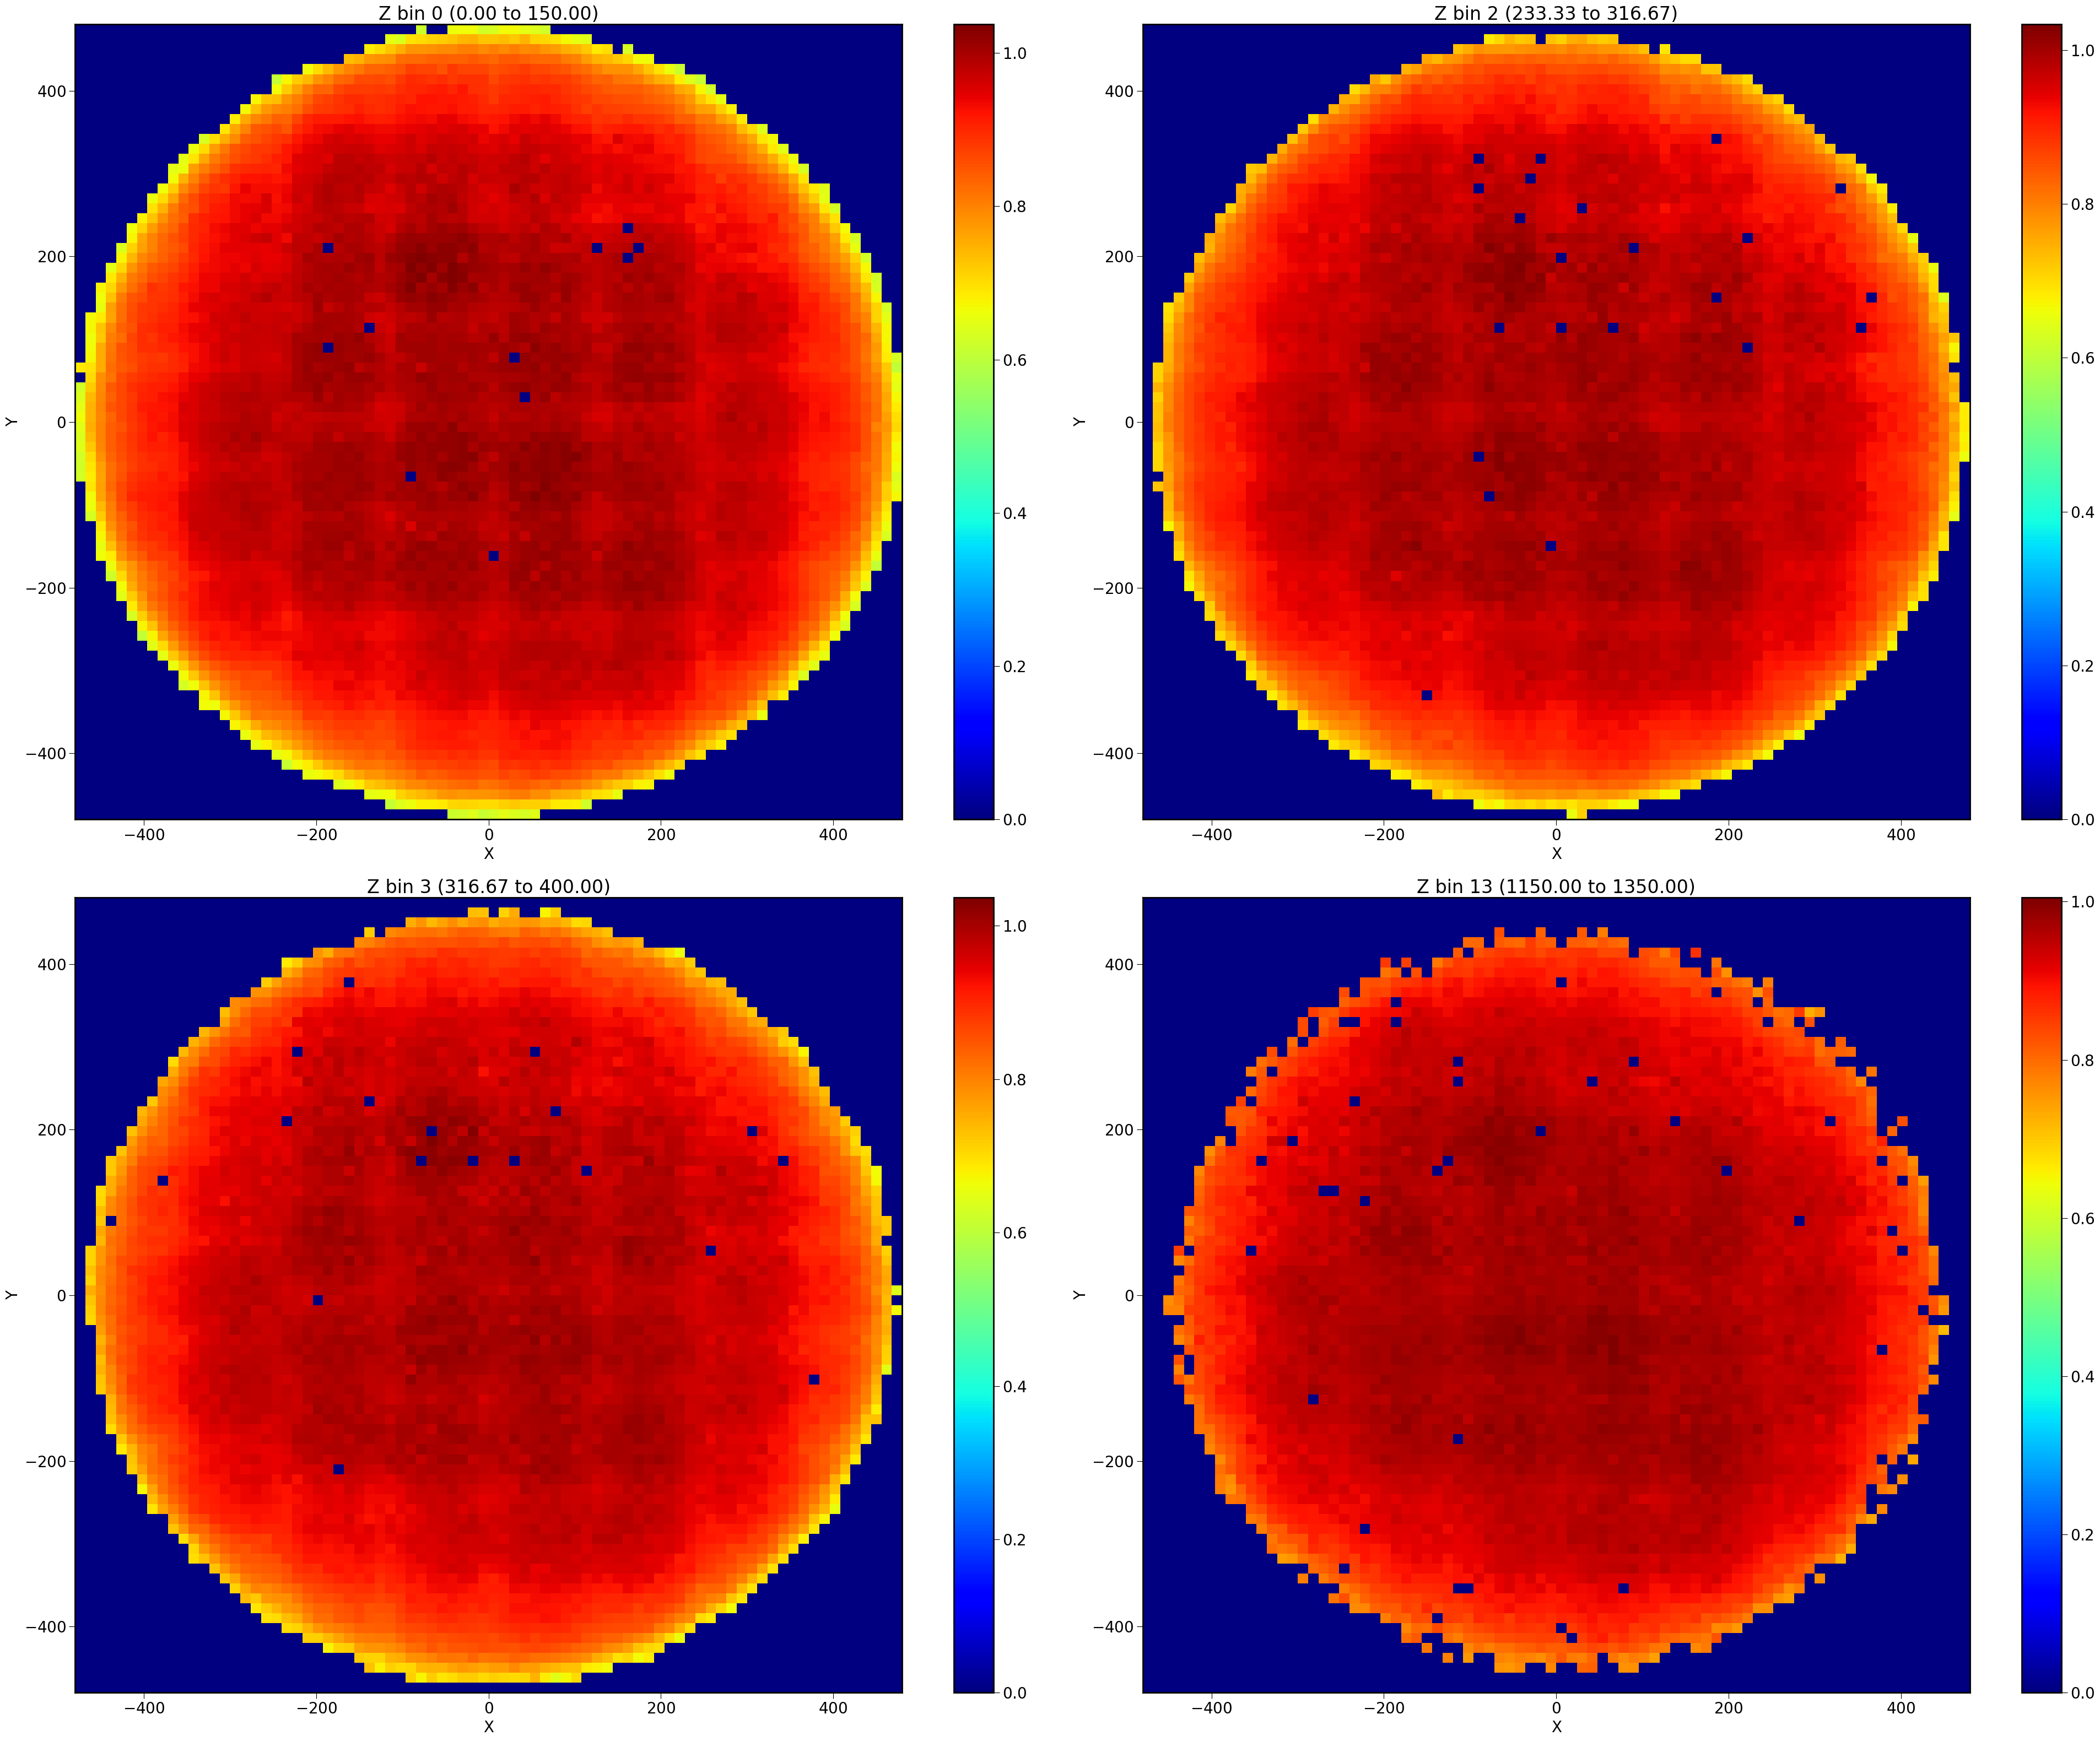

In [334]:
af.plot_3d_histogram_slices(krmap.hmap, krmap.xedges, krmap.yedges, krmap.zedges, z_indices=[0,2,3,len(z_bins)-2], figsize= (20, 16))

In [335]:
af.save_kr_map(krmap,f"../db/kr_maps/map_run{run_number}.npz")

In [267]:
Krdf = af.correct_S2e(df_single_s1_peak_geo, krmap, rmax=480.0, zmax=1350.0)

In [268]:
Krdf

,event,time,s1_peak,s2_peak,nS1,nS2,S1w,S1h,S1e,S1t,...,Z,Zrms,X,Y,R,Phi,Xrms,Yrms,Epes,corrections
137,90,1.751885e+09,1,0,2,1,150.0,1.544283,7.099424,1282625.0,...,120.875877,2.064802,-150.008124,-303.163397,338.246187,-2.030283,11.723096,11.859016,8200.175092,0.946366
181,125,1.751885e+09,7,0,8,1,175.0,1.258491,6.378206,514425.0,...,889.052917,5.473353,307.322196,-240.234880,390.076569,-0.663485,15.057715,14.364113,8957.715819,0.943035
243,153,1.751885e+09,0,0,7,1,200.0,0.638820,1.776259,113675.0,...,1290.805786,6.148438,-51.470999,-66.824969,84.349512,-2.227123,15.463147,16.120367,8381.024394,0.998209
252,174,1.751885e+09,0,0,12,1,275.0,9.353996,42.812111,511450.0,...,940.053284,5.510045,242.492484,157.536489,289.171836,0.576133,15.017830,15.880561,13353.631753,0.944110
265,181,1.751885e+09,1,0,3,1,175.0,1.776424,8.561007,570250.0,...,834.244385,5.176660,-61.560485,-251.227828,258.660231,-1.811100,14.542470,15.674585,8323.475421,0.961849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63495529,7653250,1.751972e+09,0,0,8,1,325.0,4.109981,25.171808,853725.0,...,546.764404,4.162603,38.733427,267.116279,269.909957,1.426794,14.933013,12.309101,5705.423093,0.969386
63495638,7653327,1.751972e+09,0,0,10,1,250.0,5.319927,22.932280,782675.0,...,625.807556,4.730671,320.962150,290.480636,432.892252,0.735588,16.397701,15.878964,15317.366156,0.849391
63495648,7653334,1.751972e+09,0,0,4,1,125.0,2.309831,8.942545,602975.0,...,798.500793,5.208627,82.792180,-349.358789,359.034969,-1.338106,16.387767,12.830705,8289.805488,0.932980
63495713,7653390,1.751972e+09,1,1,7,2,325.0,10.652429,63.768879,782200.0,...,771.294189,4.665284,181.585818,290.838713,342.871063,1.012663,12.730109,13.054106,5866.103381,0.943231


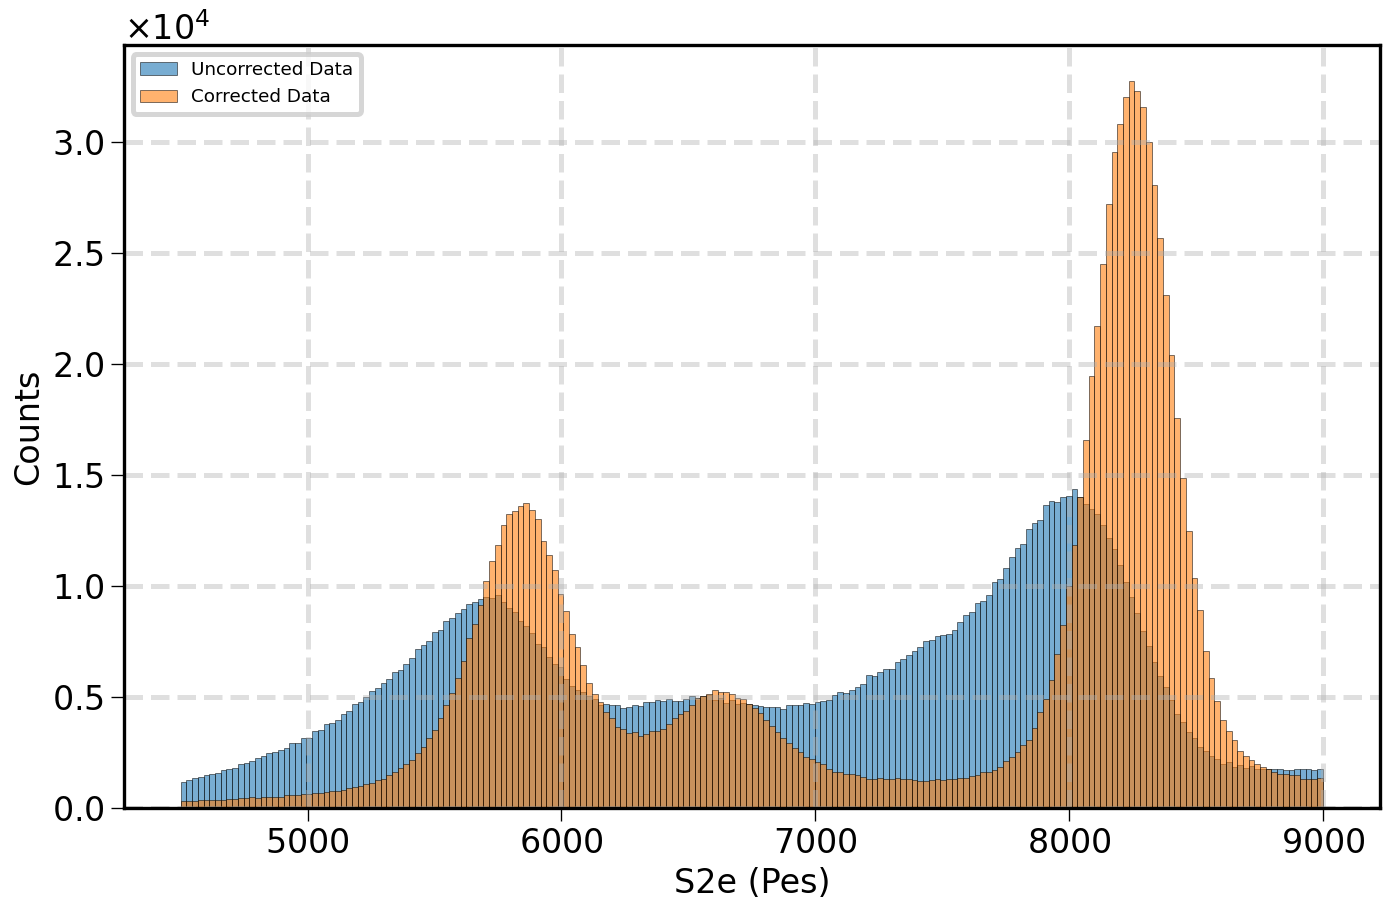

In [283]:
plt.figure(figsize=(12, 8), dpi=120)
# Plot S2e histogram
plt.hist(Krdf['S2e'], bins=200, range=(4500, 9000), alpha=0.6 , color='tab:blue', 
         edgecolor='black', linewidth=0.5, label='Uncorrected Data')

# Compute histogram
counts, bin_edges = np.histogram(Krdf['Epes'], bins=200, range=(4500, 9000))
x_max = 0.5 * (bin_edges[1:] + bin_edges[:-1])[np.argmax(counts)]
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

peaks, _ = find_peaks(counts, prominence=100)  # You can tune `height`, `distance`, etc.

assert len(peaks) == 3, f"Expected 3 peaks, but found {len(peaks)}. Check prominence and range"

peaks = bin_centers[peaks]

plt.hist(Krdf['Epes'], bins=200, range=(4500, 9000), alpha=0.6,
         color='tab:orange', edgecolor='black', linewidth=0.5,
         label='Corrected Data')

# Aesthetic settings
plt.xlabel('S2e (Pes)')
plt.ylabel('Counts')
plt.legend(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Counts')

<Figure size 1440x960 with 0 Axes>

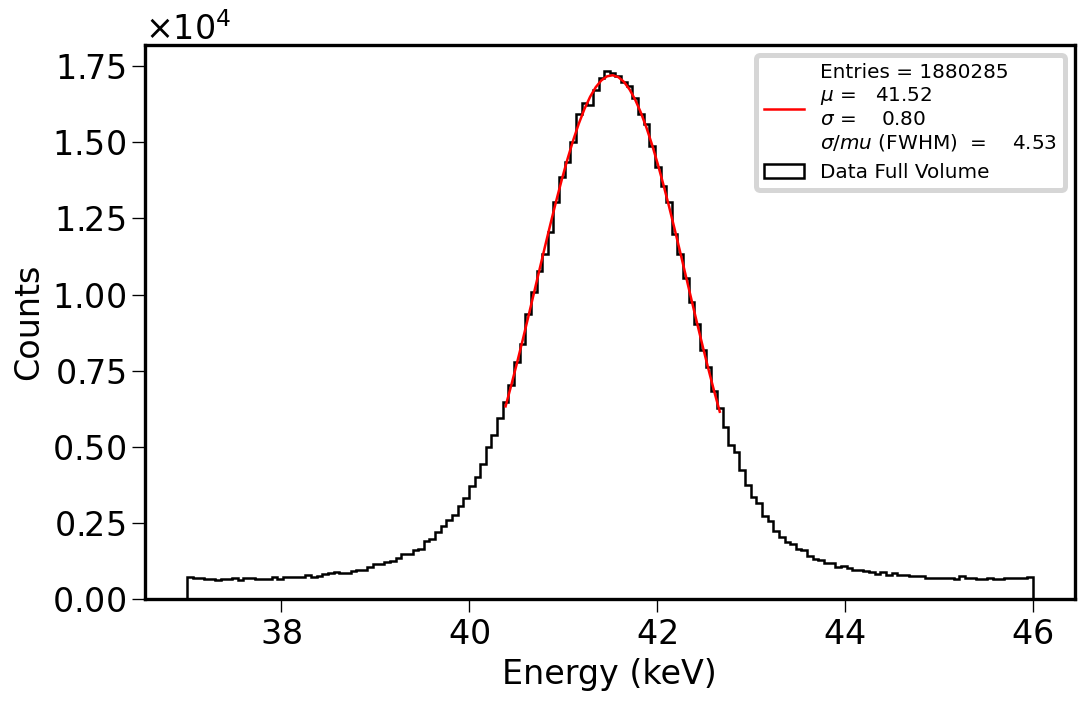

In [284]:
plt.figure(figsize=(12, 8), dpi=120)
hp = af.HistoPar(var = Krdf['Epes']/x_max*41.5, nbins = 150, range = [37, 46])
fp, fr = af.fit_energy(hp.var, hp.nbins, hp.range, n_sigma  = .9)
fc = af.FitCollection(fp, hp, fr) 
plt.figure(figsize=(10, 6), dpi=120)
af.plot_fit_energy(fc,"Data Full Volume")
plt.legend(fontsize=12)
plt.xlabel('Energy (keV)')
plt.ylabel('Counts')

Text(0, 0.5, 'Counts')

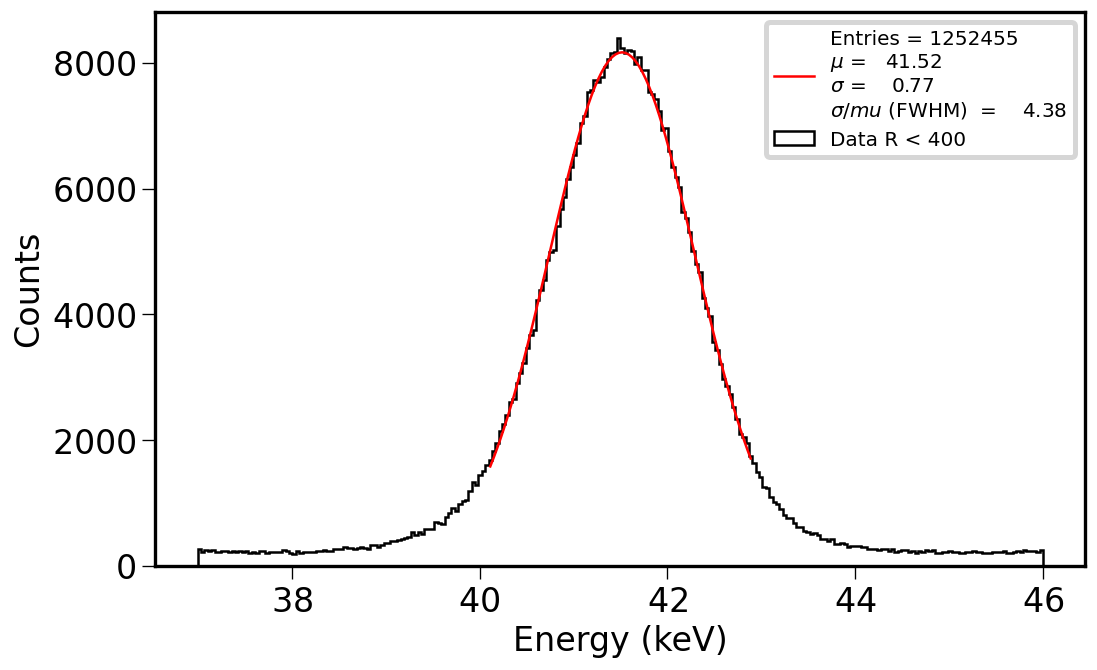

In [285]:
hp = af.HistoPar(var = Krdf[Krdf['R']<400]['Epes']/x_max*41.5, nbins = 250, range = [37, 46])
fp, fr = af.fit_energy(hp.var, hp.nbins, hp.range, n_sigma  = 1.2)
fc = af.FitCollection(fp, hp, fr) 
plt.figure(figsize=(10, 6), dpi=120)
af.plot_fit_energy(fc,"Data R < 400")
plt.legend(fontsize=12)
plt.xlabel('Energy (keV)')
plt.ylabel('Counts')

Text(0, 0.5, 'Counts')

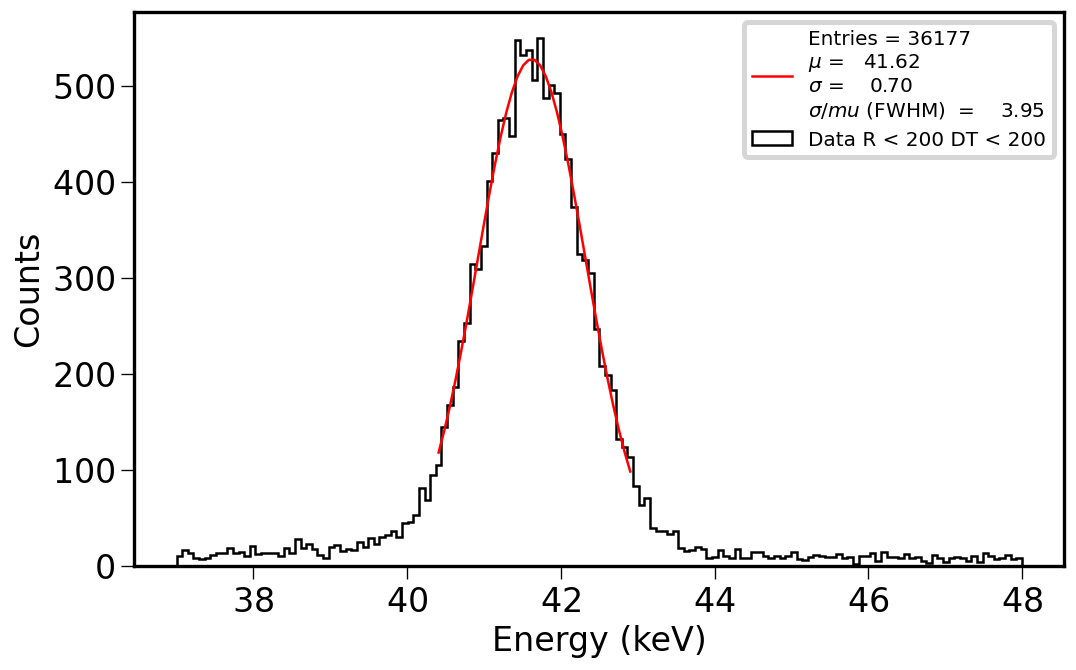

In [286]:
hp = af.HistoPar(var = Krdf[(Krdf['R']<200) & (Krdf['DT']<200)]['Epes']/x_max*41.5, nbins = 150, range = [37, 48])
fp, fr = af.fit_energy(hp.var, hp.nbins, hp.range, n_sigma  = 1.)
fc = af.FitCollection(fp, hp, fr) 
plt.figure(figsize=(10, 6), dpi=120)
af.plot_fit_energy(fc,"Data R < 200 DT < 200")
plt.legend(fontsize=12)
plt.xlabel('Energy (keV)')
plt.ylabel('Counts')

5861.25
6603.75
8246.25


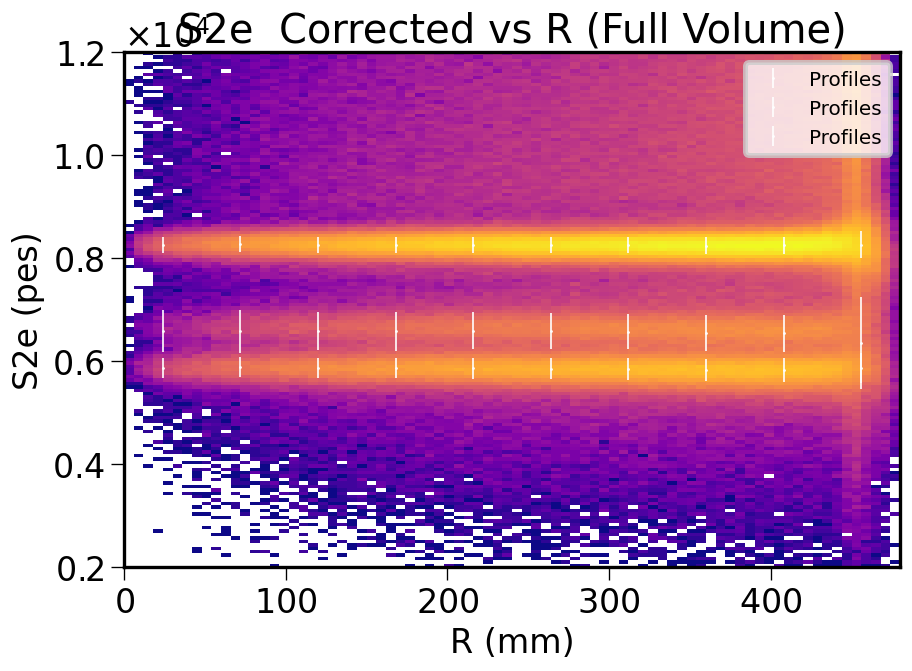

In [314]:
plt.figure(figsize=(8, 6), dpi=120)

counts2, xedges2, yedges2 = np.histogram2d(Krdf['R'], Krdf['Epes'], bins=(80,150), range=([0, 480], [2000, 12000]))
counts2[counts2 <= 1] = np.nan  # Mask bins with counts ≤ 1

plt.pcolormesh(xedges2, yedges2, counts2.T, cmap='plasma', norm = LogNorm())

dic_R_fullvol = {}

for peak in peaks:
    print(peak)
    counts, xedges, yedges = np.histogram2d(Krdf['R'], Krdf['Epes'], bins=(80,40), 
                                                     range=([0, 480], [peak-450, peak+450]))
    values = af.gaussian_profiler_y_slices(counts, xedges, yedges,10)
    dic_R_fullvol[peak] = values
    plt.errorbar(values[0], values[1], yerr=values[3], fmt='.', markersize=1.3, linewidth=1., color='w', label='Profiles')

plt.xlabel('R (mm)')
plt.ylabel('S2e (pes)')
fig.colorbar(axes[1].collections[0], ax=axes[1], label='Counts')

plt.title('S2e  Corrected vs R (Full Volume)')
plt.legend(fontsize=12)
# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

5861.25
6603.75
8246.25


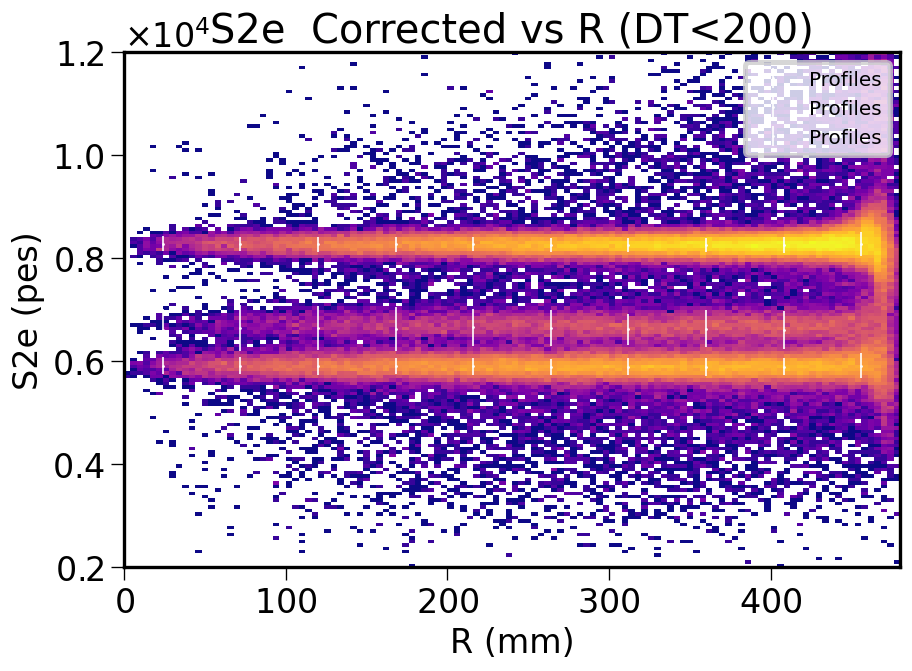

In [315]:
plt.figure(figsize=(8, 6), dpi=120)

counts2, xedges2, yedges2 = np.histogram2d(Krdf[Krdf['DT']<200]['R'], Krdf[Krdf['DT']<200]['Epes'], 
                                           bins=(120,150), range=([0, 480], [2000, 12000]))
counts2[counts2 <= 1] = np.nan  # Mask bins with counts ≤ 1

plt.pcolormesh(xedges2, yedges2, counts2.T, cmap='plasma', norm = LogNorm() )
plt.xlabel('R (mm)')
plt.ylabel('S2e (pes)')
fig.colorbar(axes[1].collections[0], ax=axes[1], label='Counts')

dic_R_smallvol = {}

for peak in peaks:
    print(peak)
    counts, xedges, yedges = np.histogram2d(Krdf[Krdf['DT']<200]['R'], Krdf[Krdf['DT']<200]['Epes'], 
                                           bins=(120,150), range=([0, 480], [peak-450, peak+450]))
    values = af.gaussian_profiler_y_slices(counts, xedges, yedges,10)
    dic_R_smallvol[peak] = values

    plt.errorbar(values[0], values[1], yerr=values[3], fmt='.', markersize=1.3, linewidth=1., color='w', label='Profiles')

plt.legend(fontsize=12)
plt.title('S2e  Corrected vs R (DT<200)')
# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

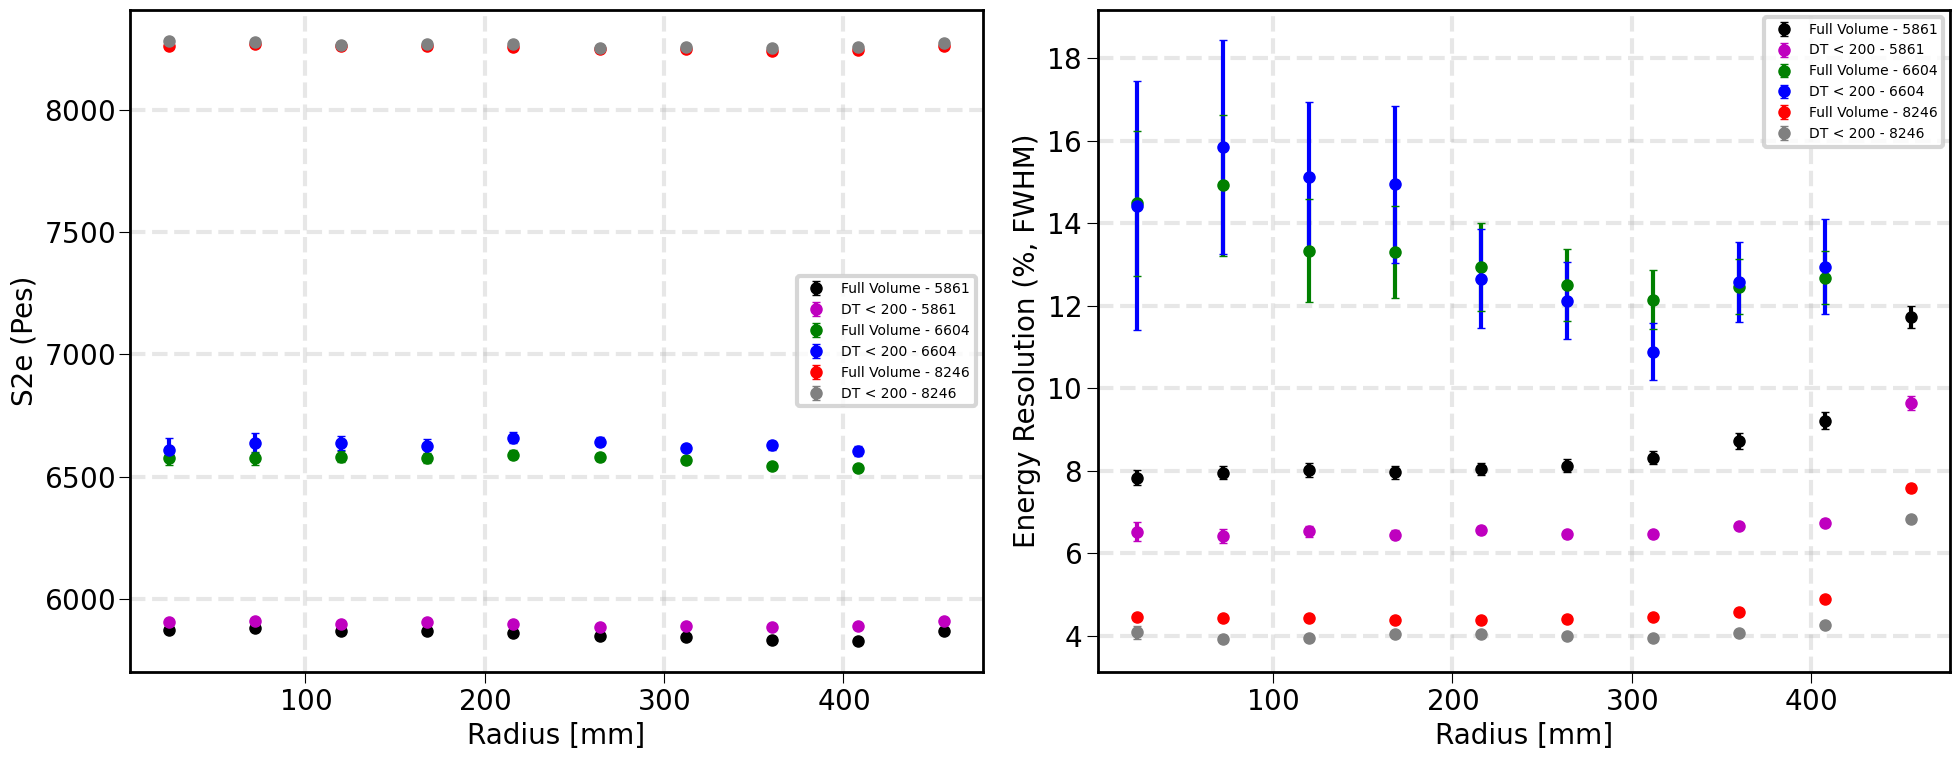

In [316]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

for k,peak in enumerate(peaks):
    r_centers, mean_vals_full_dt, mean_errs_full_dt, sigma_full_dt, sigma_errs_full_dt = dic_R_fullvol[peak]
    r_centers, mean_vals_small_dt, mean_errs_small_dt, sigma_small_dt, sigma_errs_small_dt = dic_R_smallvol[peak]
    
    resolution_full, resolution_err_full = stats.compute_resolution_with_error(abs(sigma_full_dt), sigma_errs_full_dt, mean_vals_full_dt, mean_errs_full_dt)
    resolution_small, resolution_err_small = stats.compute_resolution_with_error(abs(sigma_small_dt), sigma_errs_small_dt, mean_vals_small_dt, mean_errs_small_dt)

    # Plot 1: Mean vs. r_centers
    ax1.errorbar(r_centers, mean_vals_full_dt, yerr=mean_errs_full_dt,
             fmt='o', capsize=3, markersize=8., label=f'Full Volume - {peak:.0f}', color=color_sequence[2*k])
    ax1.errorbar(r_centers, mean_vals_small_dt, yerr=mean_errs_small_dt,
             fmt='o', capsize=3, markersize=8., label=f'DT < 200 - {peak:.0f}', color=color_sequence[2*k+1])
    ax1.set_xlabel('Radius [mm]')
    ax1.set_ylabel('S2e (Pes)')
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=10)

    # Plot 2: Resolution vs. r_centers
    ax2.errorbar(r_centers, resolution_full, yerr=resolution_err_full,
             fmt='o', capsize=3, markersize=8., color=color_sequence[2*k], label=f'Full Volume - {peak:.0f}')
    ax2.errorbar(r_centers, resolution_small, yerr=resolution_err_small,
             fmt='o', capsize=3, markersize=8., color=color_sequence[2*k+1], label=f'DT < 200 - {peak:.0f}')
    
    ax2.set_xlabel('Radius [mm]')
    ax2.set_ylabel('Energy Resolution (%, FWHM)')
    ax2.grid(True, alpha=0.3)
    #ax2.set_ylim(2,8)
    ax2.legend(fontsize=10)

plt.tight_layout()
plt.show()

5861.25
6603.75
8246.25


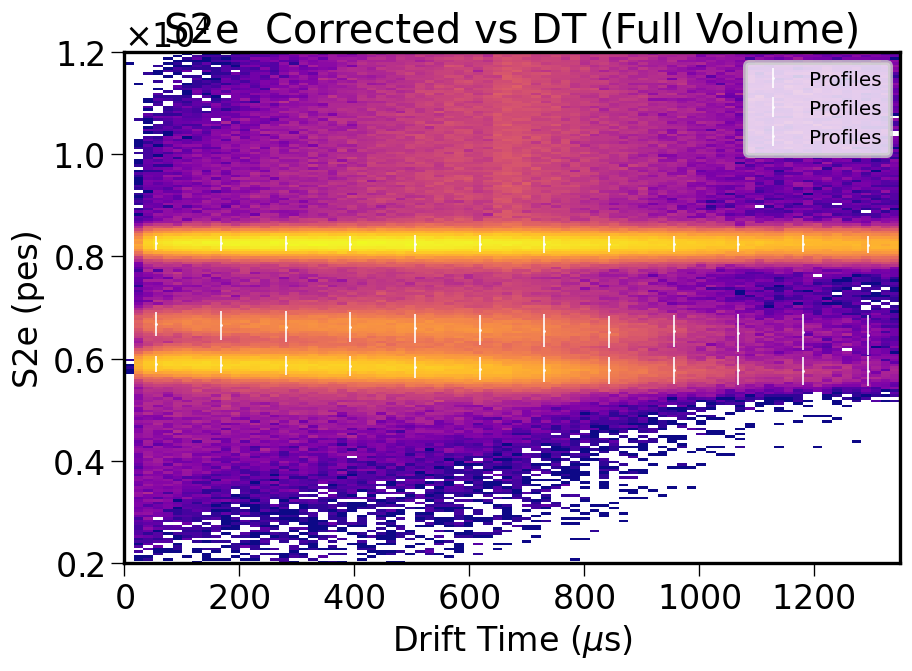

In [317]:
plt.figure(figsize=(8, 6), dpi=120)

counts2, xedges2, yedges2 = np.histogram2d(Krdf[Krdf['R']<400]['DT'], Krdf[Krdf['R']<400]['Epes'], bins=(80,200), range=([0, 1350], [2000, 12000]))
counts2[counts2 <= 1] = np.nan  # Mask bins with counts ≤ 1

plt.pcolormesh(xedges2, yedges2, counts2.T, cmap='plasma', norm = LogNorm())
plt.xlabel('Drift Time ($\mu$s)')
plt.ylabel('S2e (pes)')
fig.colorbar(axes[1].collections[0], ax=axes[1], label='Counts')

dic_DT_fullvol = {}

for peak in peaks:
    print(peak)
    counts, xedges, yedges = np.histogram2d(Krdf[Krdf['R']<400]['DT'], Krdf[Krdf['R']<400]['Epes'], 
                                            bins=(80,200), range=([0, 1350], [peak-400, peak+400]))
    
    values = af.gaussian_profiler_y_slices(counts, xedges, yedges,12)
    dic_DT_fullvol[peak] = values
    plt.errorbar(values[0], values[1], yerr=values[3], fmt='.', markersize=1.3, linewidth=1., color='w', label='Profiles')

plt.legend(fontsize=12)
plt.title('S2e  Corrected vs DT (Full Volume)')
# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

5861.25
6603.75
8246.25


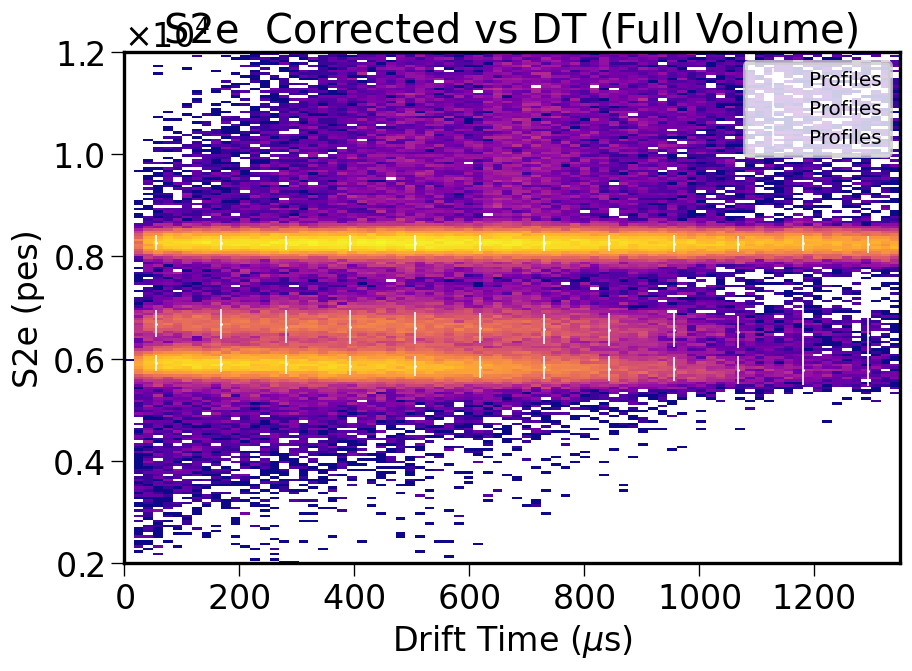

In [318]:
plt.figure(figsize=(8, 6), dpi=120)

counts2, xedges2, yedges2 = np.histogram2d(Krdf[Krdf['R']<200]['DT'], Krdf[Krdf['R']<200]['Epes'], bins=(80,200), range=([0, 1350], [2000, 12000]))
dt_centers, mean_vals_small_r, mean_errs_small_r, sigma_small_r, sigma_errs_small_r = af.gaussian_profiler_y_slices(counts2, xedges2, yedges2,12)

counts2[counts2 <= 1] = np.nan  # Mask bins with counts ≤ 1

plt.pcolormesh(xedges2, yedges2, counts2.T, cmap='plasma', norm=LogNorm())
plt.xlabel('Drift Time ($\mu$s)')
plt.ylabel('S2e (pes)')
fig.colorbar(axes[1].collections[0], ax=axes[1], label='Counts')
dic_DT_smallvol = {}

for peak in peaks:
    print(peak)
    counts, xedges, yedges = np.histogram2d(Krdf[Krdf['R']<200]['DT'], Krdf[Krdf['R']<200]['Epes'], 
                                            bins=(80,200), range=([0, 1350], [peak-400, peak+400]))
    
    values = af.gaussian_profiler_y_slices(counts, xedges, yedges,12)
    dic_DT_smallvol[peak] = values
    plt.errorbar(values[0], values[1], yerr=values[3], fmt='.', markersize=1.3, linewidth=1., color='w', label='Profiles')


plt.legend(fontsize=12)
plt.title('S2e  Corrected vs DT (Full Volume)')
# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

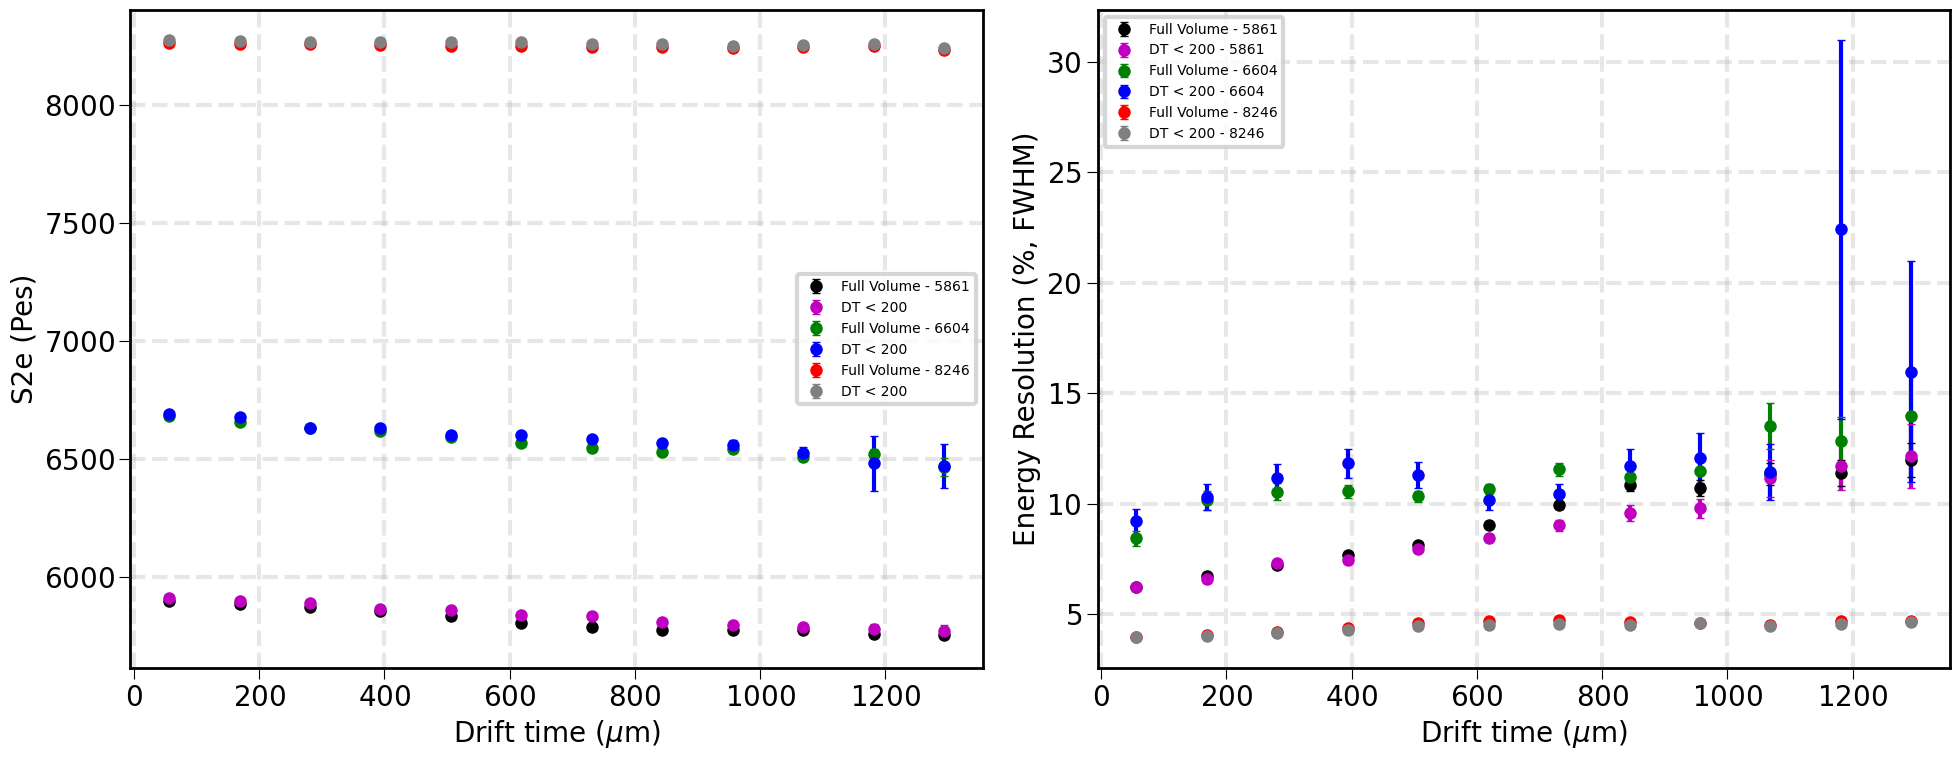

In [320]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

for k,peak in enumerate(peaks):
    dt_centers, mean_vals_full_r, mean_errs_full_r, sigma_full_r, sigma_errs_full_r = dic_DT_fullvol[peak]
    dt_centers, mean_vals_small_r, mean_errs_small_r, sigma_small_r, sigma_errs_small_r = dic_DT_smallvol[peak]

    resolution_full, resolution_err_full = stats.compute_resolution_with_error(abs(sigma_full_r), sigma_errs_full_r, mean_vals_full_r, mean_errs_full_r)
    resolution_small, resolution_err_small = stats.compute_resolution_with_error(abs(sigma_small_r), sigma_errs_small_r, mean_vals_small_r, mean_errs_small_r)

    # Plot 1: Mean vs. r_centers
    ax1.errorbar(dt_centers, mean_vals_full_r, yerr=mean_errs_full_r,
             fmt='o', capsize=3, markersize=8., label=f'Full Volume - {peak:.0f}', color=color_sequence[2*k])
    ax1.errorbar(dt_centers, mean_vals_small_r, yerr=mean_errs_small_r,
             fmt='o', capsize=3, markersize=8., label='DT < 200', color=color_sequence[2*k+1])
    ax1.set_xlabel('Drift time ($\mu$m)')
    ax1.set_ylabel('S2e (Pes)')
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=10)

    # Plot 2: Resolution vs. r_centers
    ax2.errorbar(dt_centers, resolution_full, yerr=resolution_err_full,
             fmt='o', capsize=3, markersize=8., color=color_sequence[2*k], label=f'Full Volume - {peak:.0f}')
    ax2.errorbar(dt_centers, resolution_small, yerr=resolution_err_small,
             fmt='o', capsize=3, markersize=8., color=color_sequence[2*k+1], label=f'DT < 200 - {peak:.0f}')
    
    ax2.set_xlabel('Drift time ($\mu$m)')
    ax2.set_ylabel('Energy Resolution (%, FWHM)')
    ax2.grid(True, alpha=0.3)
    #ax2.set_ylim(2,8)
    ax2.legend(fontsize=10)

plt.tight_layout()
plt.show()

### Lifetime

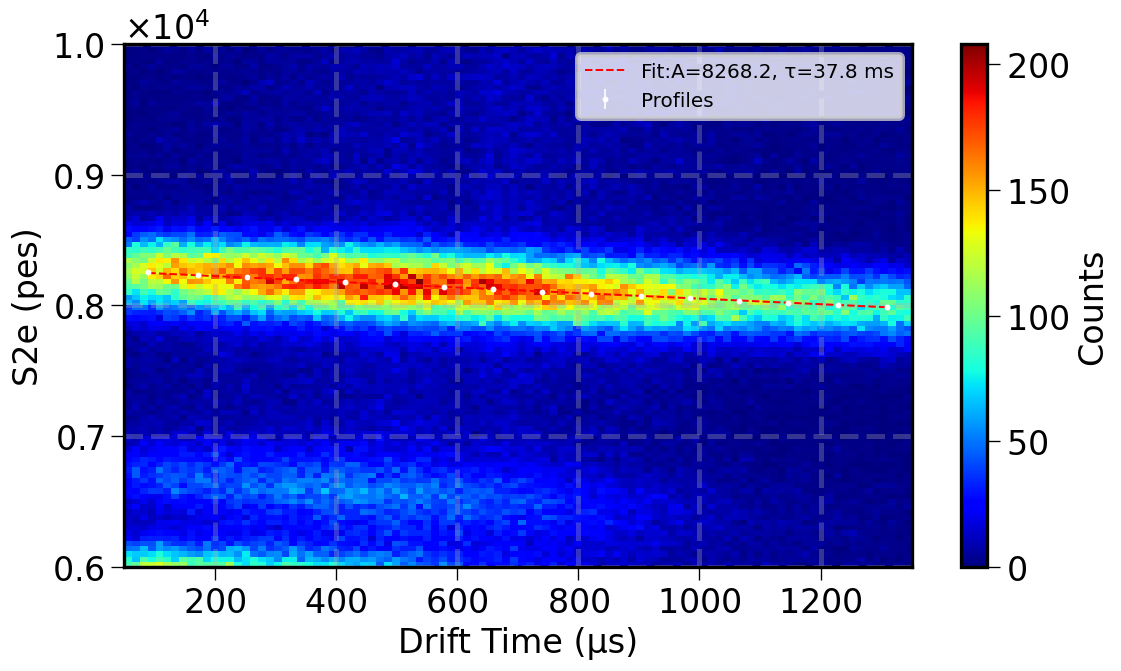

(37783.17294483698, 798.6136467682975)

In [322]:
af.fit_lifetime_Rsel(Krdf)